### Part 1:

#### Generating Platform Oscillations

This code reproduces the platform oscillations as described in the class example, implemented in Python.
The oscillations are defined for roll and pitch signals, with pauses and cycles as outlined in the example. All parameters, equations, and logic are consistent with the provided class materials.

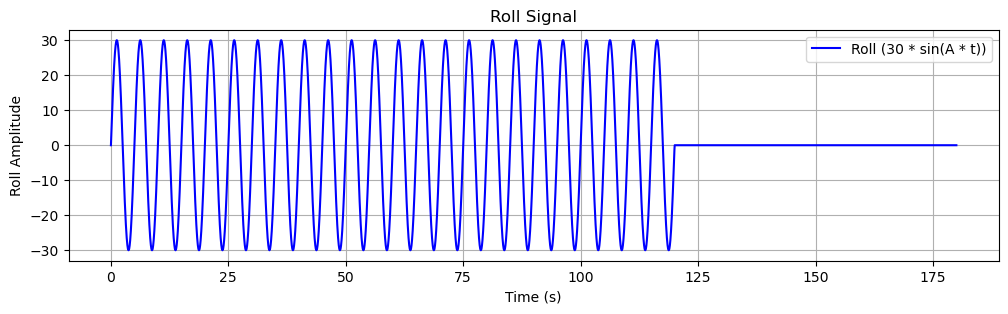

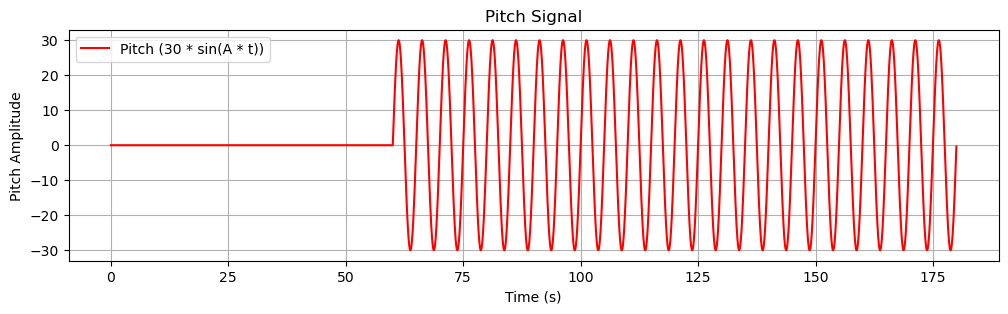

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# parameters for roll and pitch signals
freq = 0.2  
per = 1 / freq  # period of signal
A = 2 * np.pi / per  # angular frequency
Ncycle = 12 
Troll = Ncycle * per
Tpause = 0 
Ttotal = 4 * Tpause + 3 * Troll
samplefreq = 100 
total_samples = int(Ttotal * samplefreq)
time_array = np.arange(total_samples) / samplefreq 

roll = np.zeros_like(time_array)  # initialize roll array
pitch = np.zeros_like(time_array)  # initialize pitch array

for i, t in enumerate(time_array):  # generate roll signal
    if t < Tpause:  # during pause
        roll[i] = 0
    elif t < Tpause + Troll:  # during roll cycles
        roll[i] = 30 * np.sin(A * t)
    elif t < 2 * Tpause + Troll:  # next pause
        roll[i] = 0
    elif t < 2 * (Tpause + Troll):  # next roll cycles
        roll[i] = 30 * np.sin(A * t)
    else:  # after cycles
        roll[i] = 0

for i, t in enumerate(time_array):  # generate pitch signal
    if t < 2 * Tpause + Troll:  # initial pause
        pitch[i] = 0
    elif t < 2 * (Tpause + Troll):  # first pitch cycles
        pitch[i] = 30 * np.sin(A * t)
    elif t < 3 * Tpause + 2 * Troll:  # next pause
        pitch[i] = 0
    elif t < 3 * (Tpause + Troll):  # next pitch cycles
        pitch[i] = 30 * np.sin(A * t)
    else:  # after cycles
        pitch[i] = 0

plt.figure(figsize=(12, 3))  # plot roll signal
plt.plot(time_array, roll, label="Roll (30 * sin(A * t))", color="blue")
plt.xlabel('Time (s)')
plt.ylabel('Roll Amplitude')
plt.title('Roll Signal')
plt.grid(True)
plt.legend()

plt.figure(figsize=(12, 3))  # plot pitch signal
plt.plot(time_array, pitch, label="Pitch (30 * sin(A * t))", color="red")
plt.xlabel('Time (s)')
plt.ylabel('Pitch Amplitude')
plt.title('Pitch Signal')
plt.grid(True)
plt.legend()

### Adaptive Filters - Reading the Accelerometer

This code creates `AccXi` by calculating acceleration using the gravity constant and pitch angle.

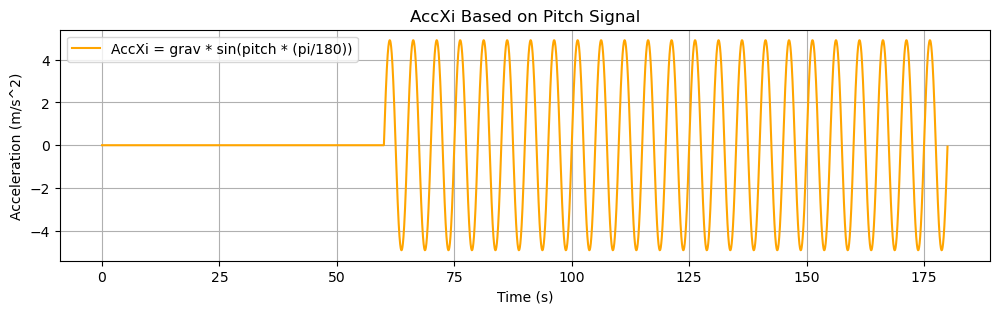

In [6]:
grav = 9.807  # gravity constant in m/s^2
AccXi = grav * np.sin(pitch * (np.pi / 180))  # calculate AccXi using pitch converted to radians

plt.figure(figsize=(12, 3))
plt.plot(time_array, AccXi, label="AccXi = grav * sin(pitch * (pi/180))", color="orange")  # plot AccXi
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('AccXi Based on Pitch Signal')
plt.grid(True)
plt.legend()


### Modeling Accelerometer Accuracy and Helicopter Movement

This code simulates helicopter movement as measured by two accelerometers with different accuracy levels and biases.
- **Sensor Accuracy**:
  - Sensor 1 has 3% accuracy and a bias of 3 m/s².
  - Sensor 2 has 0.5% accuracy and no bias.
- **Simulation**:
  - Random noise is added to replicate real-world conditions.
  - `MAccX1`: Sensor 1 measurements (higher noise and bias).
  - `MAccX2`: Sensor 2 measurements (lower noise and no bias).
- **Plots**:
  - Three zoomed-in time ranges are plotted.
  - The plots compare sensor readings, showing the effects of accuracy and bias.

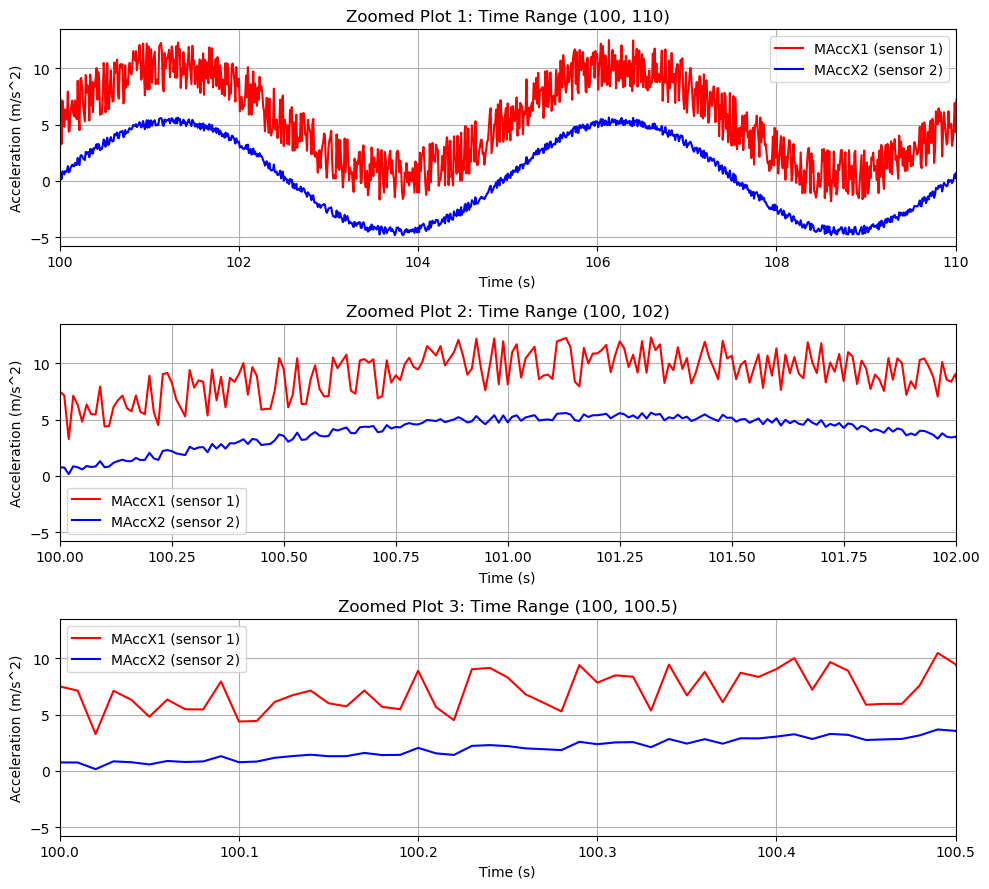

In [9]:
accMaxMes = 8 * 9.807  # maximum measurable acceleration for sensors

Accacc1 = 0.03 * accMaxMes        # sensor 1 accuracy (3% of full scale)
Accacc2 = 0.005 * accMaxMes       # sensor 2 accuracy (0.5% of full scale)
accoffset1 = 3                    # bias for sensor 1
accoffset2 = 0                    # bias for sensor 2

err = np.random.uniform(-1, 1, len(AccXi))  # random error for measurements

MAccX1 = AccXi + accoffset1 + (1 - err) * Accacc1  # sensor 1 measurements with bias and accuracy
MAccX2 = AccXi + accoffset2 + (1 - err) * Accacc2  # sensor 2 measurements with bias and accuracy

x_boundary = [(100, 110), (100, 102), (100, 100.5)]  # time ranges for zoomed plots
fig, axes = plt.subplots(3, 1, figsize=(10, 9))  # set up figure with subplots

for i, ax in enumerate(axes):
    ax.plot(time_array, MAccX1, label="MAccX1 (sensor 1)", color="red")  # plot sensor 1 data
    ax.plot(time_array, MAccX2, label="MAccX2 (sensor 2)", color="blue")  # plot sensor 2 data
    ax.set_xlim(x_boundary[i])  # set time range for each plot
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (m/s^2)')
    ax.set_title(f'Zoomed Plot {i+1}: Time Range {x_boundary[i]}')  # plot title for each range
    ax.grid(True)
    ax.legend()

plt.tight_layout()

### LMS Algorithm for IMU Example

This function implements the Least Mean Squares (LMS) algorithm, following the exact structure used in the IMU example

In [12]:
def LMS_example(u, d, w, M, totSamples, miu):
    evec = np.zeros(totSamples)  # initialize error vector
    nn = M - 1  # start from M-1 to ensure valid indexing
    while nn < totSamples - 1:  # iterate over the total samples
        ii = M - 1  # initialize filter coefficient index
        dd = d[nn]  # desired signal at the current sample
        fir = 0  # initialize filter output
        while ii >= 0:  # iterate over filter coefficients
            uu = u[nn - M + ii + 1]  # input sample for the current filter coefficient
            fir += w[nn, ii] * uu  # accumulate weighted input
            ii -= 1  # decrement filter coefficient index
        
        ee = dd - fir  # compute error between desired and actual output
        evec[nn] = ee  # store the error
        
        ii = M - 1  # reinitialize filter coefficient index
        while ii >= 0:  # update filter coefficients
            uu = u[nn - M + ii + 1]  # input sample for the current filter coefficient
            w[nn + 1, ii] = w[nn, ii] + miu * ee * uu  # LMS weight update rule
            ii -= 1  # decrement filter coefficient index
        
        nn += 1  # move to the next sample
    
    return w, evec  # return updated weights and error vector

#### Make and Run Adaptive Filter (LMS)

This code applies the Least Mean Squares (LMS) algorithm to filter noisy sensor data, testing different values of `M` (filter length) and `miu` (step size). The goal is to see how these settings affect the filtering performance.

### Observations:
The filtering results depend on the chosen `M` and `miu` values:
- **Higher M values** make the filter more stable but slower to adapt to changes.
- **Larger miu values** allow faster adaptation but can cause instability or amplify noise.

The plots show the trade-off between filtering accuracy and stability with different parameter choices.

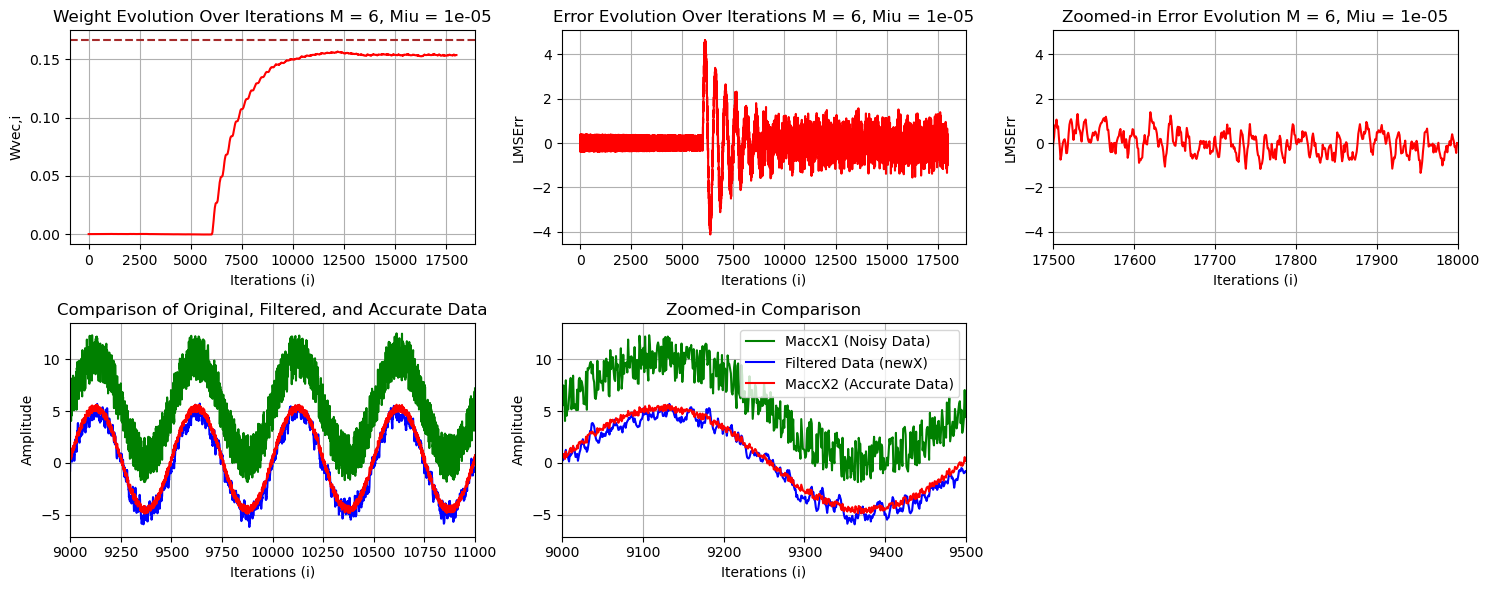

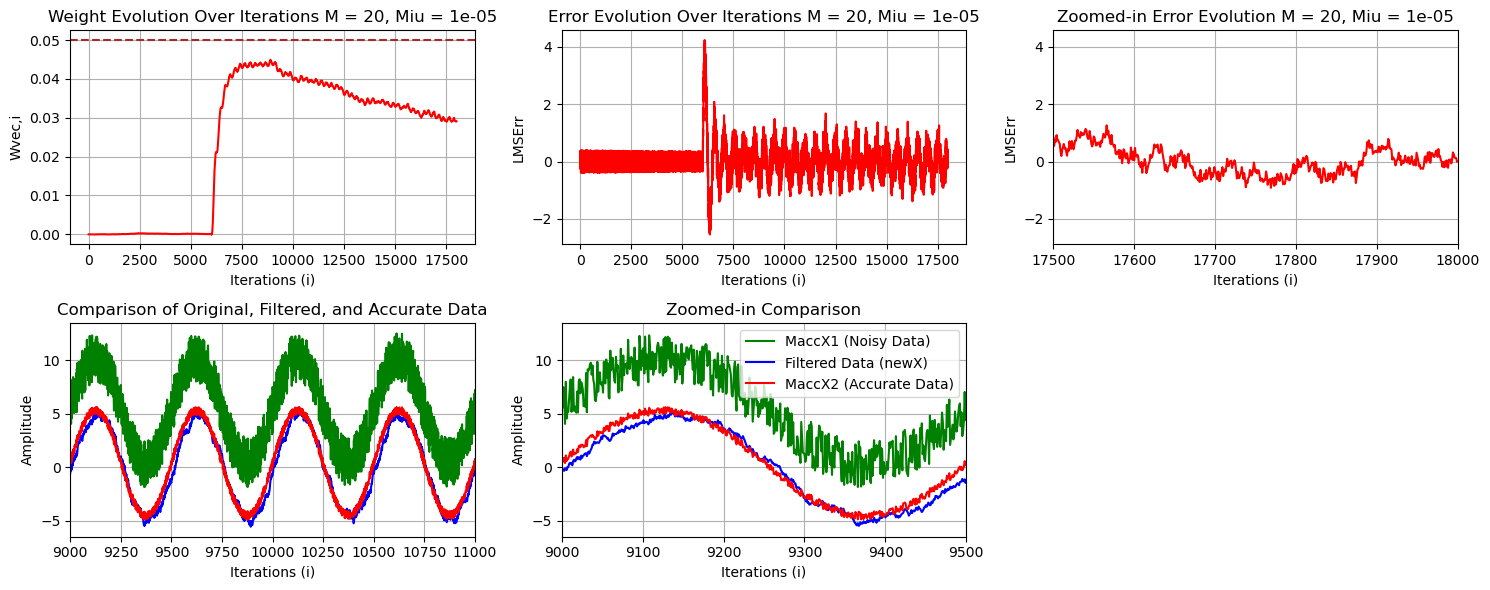

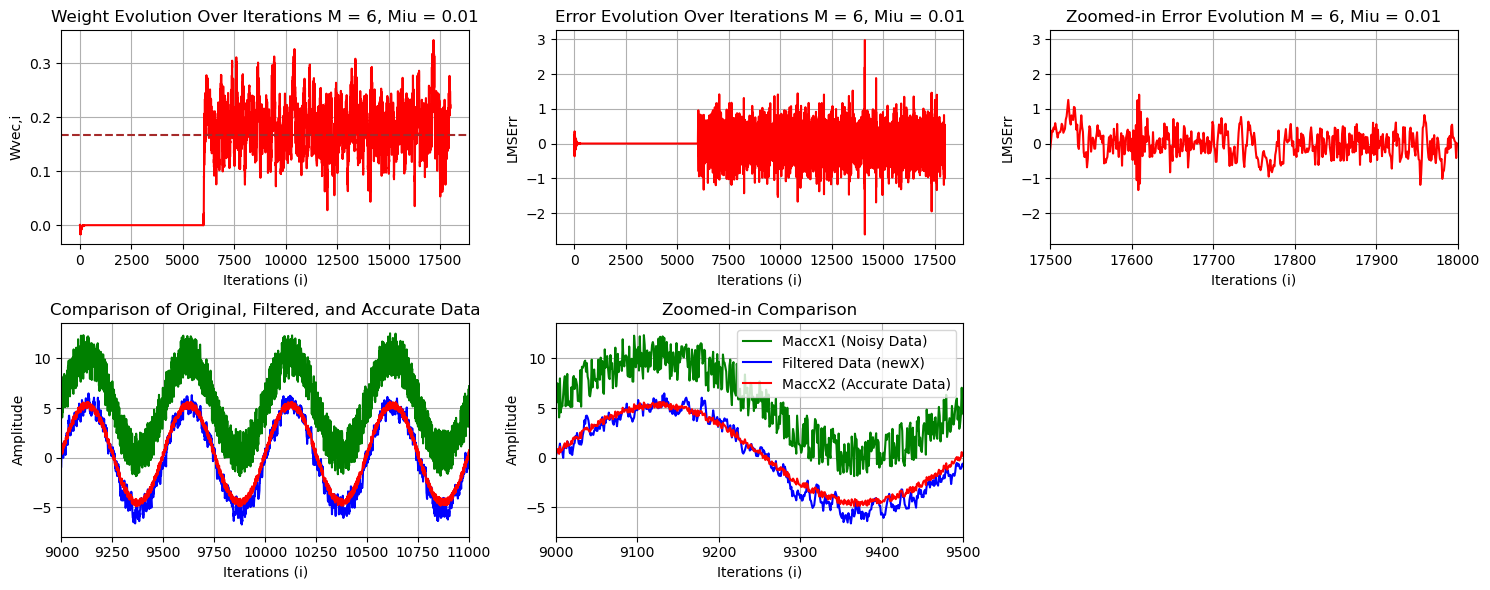

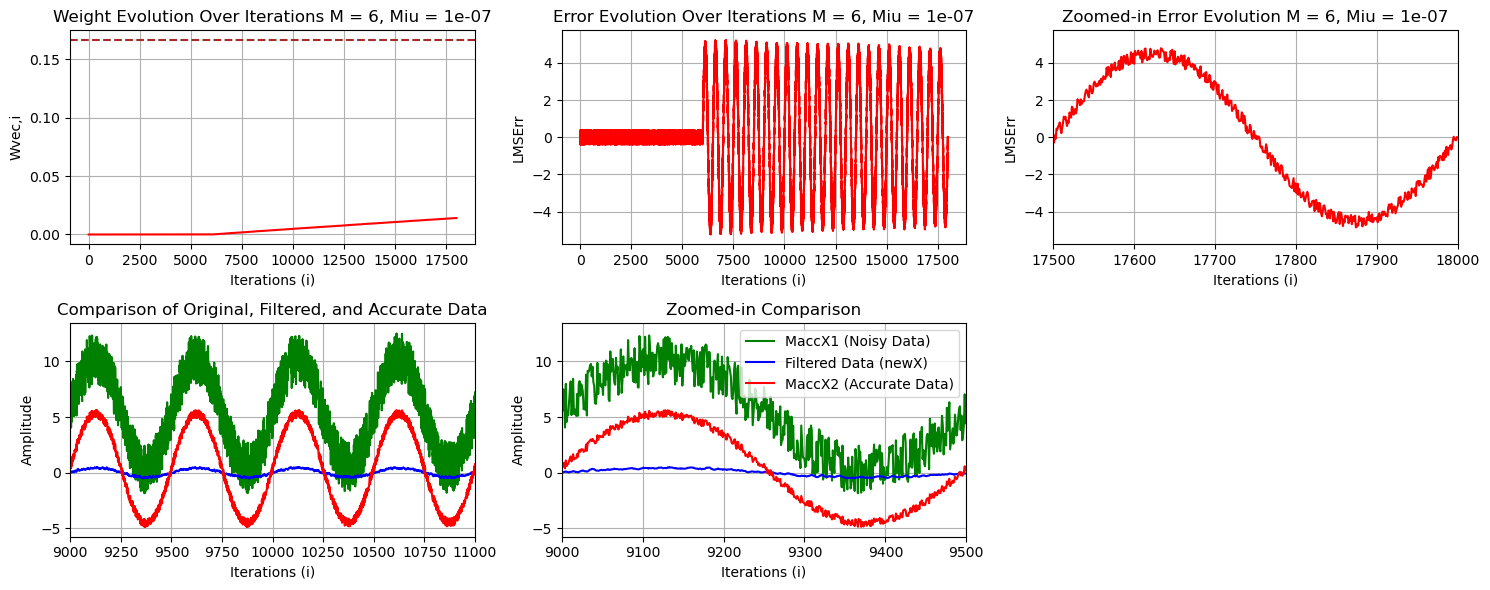

In [15]:
Avg1 = np.mean(MAccX1)           # average of MAccX1
Avg2 = np.mean(MAccX2)           # average of MAccX2

MAccXX1 = MAccX1 - Avg1          # center MAccX1
MAccXX2 = MAccX2 - Avg2          # center MAccX2

totSamples = int(1.8 * 10 ** 4)  # total samples for LMS

different_example = [(6, 0.000010), (20, 0.000010), (6, 0.010), (6, 0.00000010)]  # configurations for M and miu

for M, miu in different_example:
    fig = plt.figure(figsize=(15, 6))
    
    w = np.zeros((totSamples, M))  # initialize weight matrix
    
    LMSrun = LMS_example(MAccXX1, MAccXX2, w, M, totSamples, miu)  # apply LMS
    newW, LMSErr = LMSrun          # updated weights and error vector
    
    Wvec = newW[:, 0]              # extract the first weight across iterations

    plt.subplot(2, 3, 1)
    plt.plot(Wvec, color='red', label='Wvec')  # plot weight evolution
    plt.axhline(y=1 / M, color='brown', linestyle='--', label='1/M')  # reference line
    plt.xlabel('Iterations (i)')
    plt.ylabel('Wvec,i')
    plt.title(f'Weight Evolution Over Iterations M = {M}, Miu = {miu}')
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(LMSErr, color='red', label='LMSErr')  # plot error evolution
    plt.xlabel('Iterations (i)')
    plt.ylabel('LMSErr')
    plt.title(f'Error Evolution Over Iterations M = {M}, Miu = {miu}')
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(LMSErr, color='red', label='LMSErr')  # zoomed-in error evolution
    plt.xlabel('Iterations (i)')
    plt.ylabel('LMSErr')
    plt.xlim(17500, 18000)         # zoom to last 500 iterations
    plt.title(f'Zoomed-in Error Evolution M = {M}, Miu = {miu}')
    plt.grid(True)

    Offset = 1
    Wset = newW[totSamples - Offset, :]  # final weights
    newi = np.arange(M, totSamples)     # valid range for filtered data
    newX = np.zeros(len(newi))          # initialize filtered data

    for i in range(len(newi)):
        for k in range(M):
            newX[i] += Wset[k] * MAccXX1[newi[i] - k]  # apply filter weights

    plt.subplot(2, 3, 4)
    plt.plot(np.arange(totSamples), MAccX1, label="MaccX1 (Noisy Data)", color='green')  # noisy data
    plt.plot(newi, newX, label="Filtered Data (newX)", color='blue')  # filtered data
    plt.plot(np.arange(totSamples), MAccX2, label="MaccX2 (Accurate Data)", color='red')  # accurate data
    plt.xlabel('Iterations (i)')
    plt.ylabel('Amplitude')
    plt.title('Comparison of Original, Filtered, and Accurate Data')
    plt.xlim(9000, 11000)         # focus range
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(np.arange(totSamples), MAccX1, label="MaccX1 (Noisy Data)", color='green')  # noisy data
    plt.plot(newi, newX, label="Filtered Data (newX)", color='blue')  # filtered data
    plt.plot(np.arange(totSamples), MAccX2, label="MaccX2 (Accurate Data)", color='red')  # accurate data
    plt.xlabel('Iterations (i)')
    plt.ylabel('Amplitude')
    plt.title('Zoomed-in Comparison')
    plt.xlim(9000, 9500)          # narrow zoom range
    plt.grid(True)
    plt.legend()

    plt.tight_layout()          

---

### Part 2:


### Simplified LMS Algorithm

This function implements a simplified version of the Least Mean Squares (LMS) algorithm, designed for the IMU example.

- It uses efficient operations like `np.dot` and slicing to make the code cleaner and easier to understand.
- The algorithm calculates the error, updates filter weights, and tracks changes in total squared error to monitor convergence.

In [20]:
def LMS(u, d, w, M, totSamples, miu):
    
    evec = np.zeros(totSamples)  # initialize error vector
    error_changes = []  # store error changes over iterations
    prev_error = np.inf  # track previous error for comparison

    for nn in range(M - 1, totSamples - 1):
        yn = np.dot(w[nn, :], u[nn - M + 1: nn + 1][::-1])  # filter output
        
        ee = d[nn] - yn  # calculate error between desired and filter output
        evec[nn] = ee  # store the error
        
        w[nn + 1, :] = w[nn, :] + miu * ee * np.array(u[nn - M + 1: nn + 1][::-1])  # update weights
        
        current_error = np.sum(evec**2)  # calculate total squared error
        error_change = abs(current_error - prev_error)  # calculate error change
        error_changes.append(error_change)  # store error change
        prev_error = current_error  # update previous error

    return w, evec, error_changes  # return weights, error vector, and error changes

### Diagonal Zigzag Flattening and Unflattening of a 2D Matrix

To convert a 2D image into a 1D array, ensuring that adjacent elements in the 1D array are related (i.e., `u(n+1)` and `u(n)` are spatially close in the original image), I used a **diagonal zigzag flattening** method. This approach keeps neighboring pixels close together in the 1D representation, preserving local continuity in the signal.

This method addresses the requirement:
> If you are using a picture as a signal, ensure that the pixels are all next to each other, so that `u(n+1)` and `u(n)` have something to do with each other, and are not at different sides of the picture.

### Steps

1. **Flattening with Diagonal Zigzag**:
   - Traverse each diagonal of the matrix, one at a time, starting from the top-left.
   - Alternate traversal direction for each diagonal:
     - For even-numbered diagonals, traverse from **bottom to top**.
     - For odd-numbered diagonals, traverse from **top to bottom**.
   - Append each accessed element to a result list, building a 1D array that reflects the diagonal zigzag pattern of the original matrix.

2. **Unflattening with Diagonal Zigzag**:
   - Start with an empty matrix of the same dimensions.
   - Traverse the 1D array in the same diagonal zigzag pattern, filling in the matrix with values from the array.
   - For each diagonal, alternate between bottom-to-top and top-to-bottom traversal to place elements back in their original positions.

This zigzag approach ensures that adjacent elements in the 1D array represent nearby pixels in the original image, making it suitable for use in filtering or other signal processing tasks.

In [23]:
def flatten_zigzag_diagonal(matrix):
    M, N = len(matrix), len(matrix[0])  # Get matrix dimensions
    result = []  # Initialize result list for 1D output

    for diag in range(M + N - 1):
        if diag % 2 == 0:
            # Traverse from bottom to top
            row = min(diag, M - 1)
            col = diag - row
            while row >= 0 and col < N:
                result.append(matrix[row][col])  # Append current element to result
                row -= 1
                col += 1
        else:
            # Traverse from top to bottom
            col = min(diag, N - 1)
            row = diag - col
            while col >= 0 and row < M:
                result.append(matrix[row][col])  # Append current element to result
                row += 1
                col -= 1

    return result  # Return the 1D zigzagged array

def unflatten_zigzag_diagonal(array, M, N):
    matrix = [[0] * N for _ in range(M)]  # Initialize MxN matrix
    index = 0  # Initialize index for array

    for diag in range(M + N - 1):
        if diag % 2 == 0:
            # Traverse from bottom to top
            row = min(diag, M - 1)
            col = diag - row
            while row >= 0 and col < N:
                matrix[row][col] = array[index]  # Place element in matrix
                index += 1
                row -= 1
                col += 1
        else:
            # Traverse from top to bottom
            col = min(diag, N - 1)
            row = diag - col
            while col >= 0 and row < M:
                matrix[row][col] = array[index]  # Place element in matrix
                index += 1
                row += 1
                col -= 1

    return matrix  # Return the reconstructed matrix

### Image Preprocessing: Creating a Noisy Signal for LMS Denoising

This code prepares an image for LMS-based denoising:

1. **Grayscale Conversion**: An image is loaded and converted to grayscale.
2. **Resizing**: The image is resized to 300x300 pixels.
3. **Centering**: The mean value of the image is subtracted to create a zero-mean desired image.
4. **Noise Generation**: Gaussian noise with zero mean, scaled by a specified noise level, is generated.
5. **Adding Noise**: The generated noise is added to the zero-mean image to produce a noisy version.

The resulting noisy image is now ready for LMS denoising in subsequent steps.

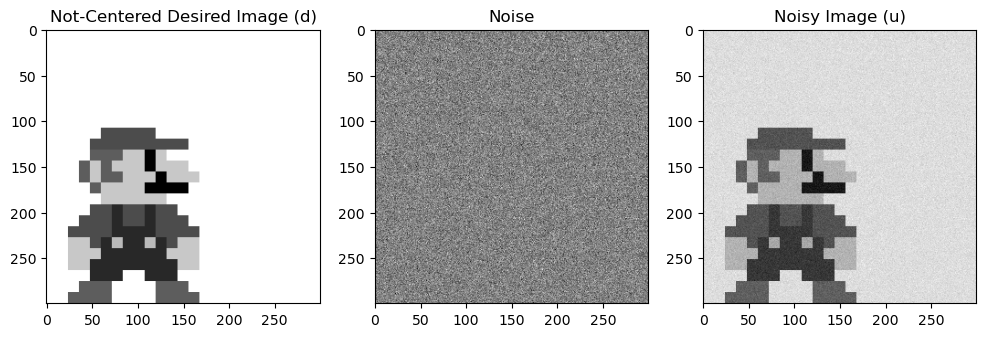

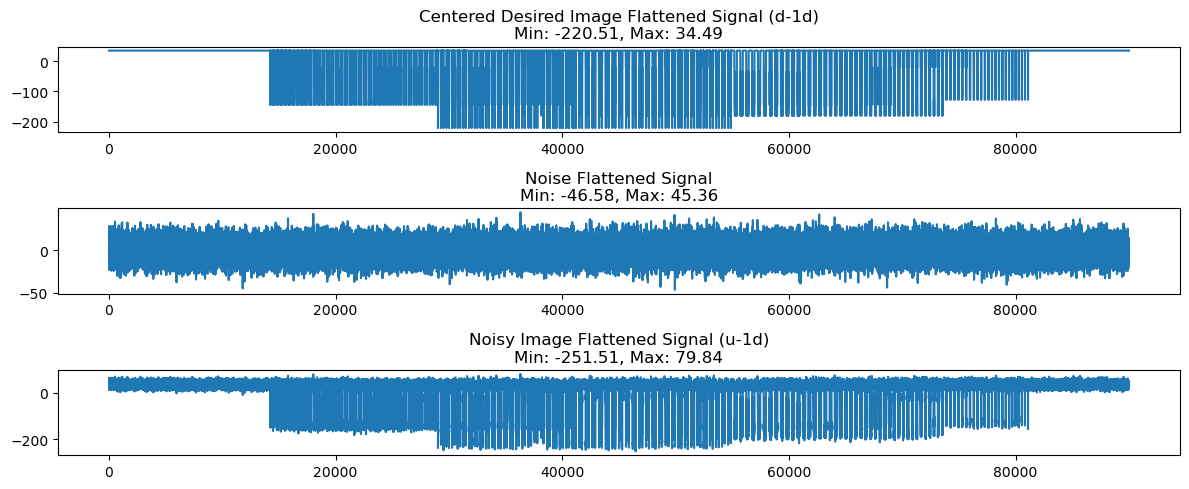

In [27]:
# Load and preprocess the image
image = cv.imread('mario.png', cv.IMREAD_GRAYSCALE)  # load image in grayscale
image = cv.resize(image, (300, 300))  # resize to 300x300

# Generate centered image and add noise
d = image - np.mean(image)  # create centered desired image
noise_level = 10  # define noise level
noise = np.random.normal(0, noise_level, size=image.shape)  # generate Gaussian noise
u = d + noise  # add noise to the centered image to create the noisy image

# Visualize images
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(d + np.mean(image), cmap='gray')  # add mean back for visualization
plt.title('Not-Centered Desired Image (d)')

plt.subplot(1, 3, 2)
plt.imshow(noise, cmap='gray')  # plot noise
plt.title('Noise')

plt.subplot(1, 3, 3)
plt.imshow(u + np.mean(image), cmap='gray')  # add mean back for visualization
plt.title('Noisy Image (u)')

# Visualize 1D flattened signals with min/max in titles
fig = plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
plt.plot(flatten_zigzag_diagonal(d))  # flattened centered desired image
plt.title(f'Centered Desired Image Flattened Signal (d-1d)\nMin: {d.min():.2f}, Max: {d.max():.2f}')

plt.subplot(3, 1, 2)
plt.plot(flatten_zigzag_diagonal(noise))  # flattened noise signal
plt.title(f'Noise Flattened Signal\nMin: {noise.min():.2f}, Max: {noise.max():.2f}')

plt.subplot(3, 1, 3)
plt.plot(flatten_zigzag_diagonal(u))  # flattened noisy image
plt.title(f'Noisy Image Flattened Signal (u-1d)\nMin: {u.min():.2f}, Max: {u.max():.2f}')

plt.tight_layout()  # adjust layout for better visualization

### Applying LMS Algorithm for Noise Filtering and Image Denoising

This code demonstrates how the LMS algorithm can filter noise from an image and reconstruct a denoised version.

#### Steps:
1. **Set LMS Parameters**:
   - Configure `M` (filter size) and `miu` (step size).

2. **Prepare Signals**:
   - Flatten the noisy signal (`u`) and the desired signal (`d`) into 1D arrays using a zigzag pattern.

3. **Apply LMS Algorithm**:
   - Compute adaptive weights and track errors at each iteration to minimize noise.

4. **Error and Weight Analysis**:
   - Plot the instantaneous error and total error changes to monitor convergence.
   - Visualize the evolution of individual weights and the last weight during the filtering process.

5. **Filter Noisy Signal**:
   - Use the final weights to process the noisy signal and generate a denoised 1D signal.

6. **Reconstruct Denoised Image**:
   - Add the mean back to the denoised signal to restore the original intensity range.
   - Clip values to the valid range (0–255) to ensure valid pixel intensities.
   - Convert the 1D signal back into a 2D image.

7. **Visualization**:
   - Compare original, noisy, and denoised images.
   - Plot noisy vs. denoised signals and original vs. denoised signals.

#### Observations:
- From the output plots, we observe that after around **50000 iterations**, the weights stabilize, and the error no longer changes significantly. 
- At this point, the LMS algorithm could be stopped, and the weights at iteration **50000** can be used for further filtering.


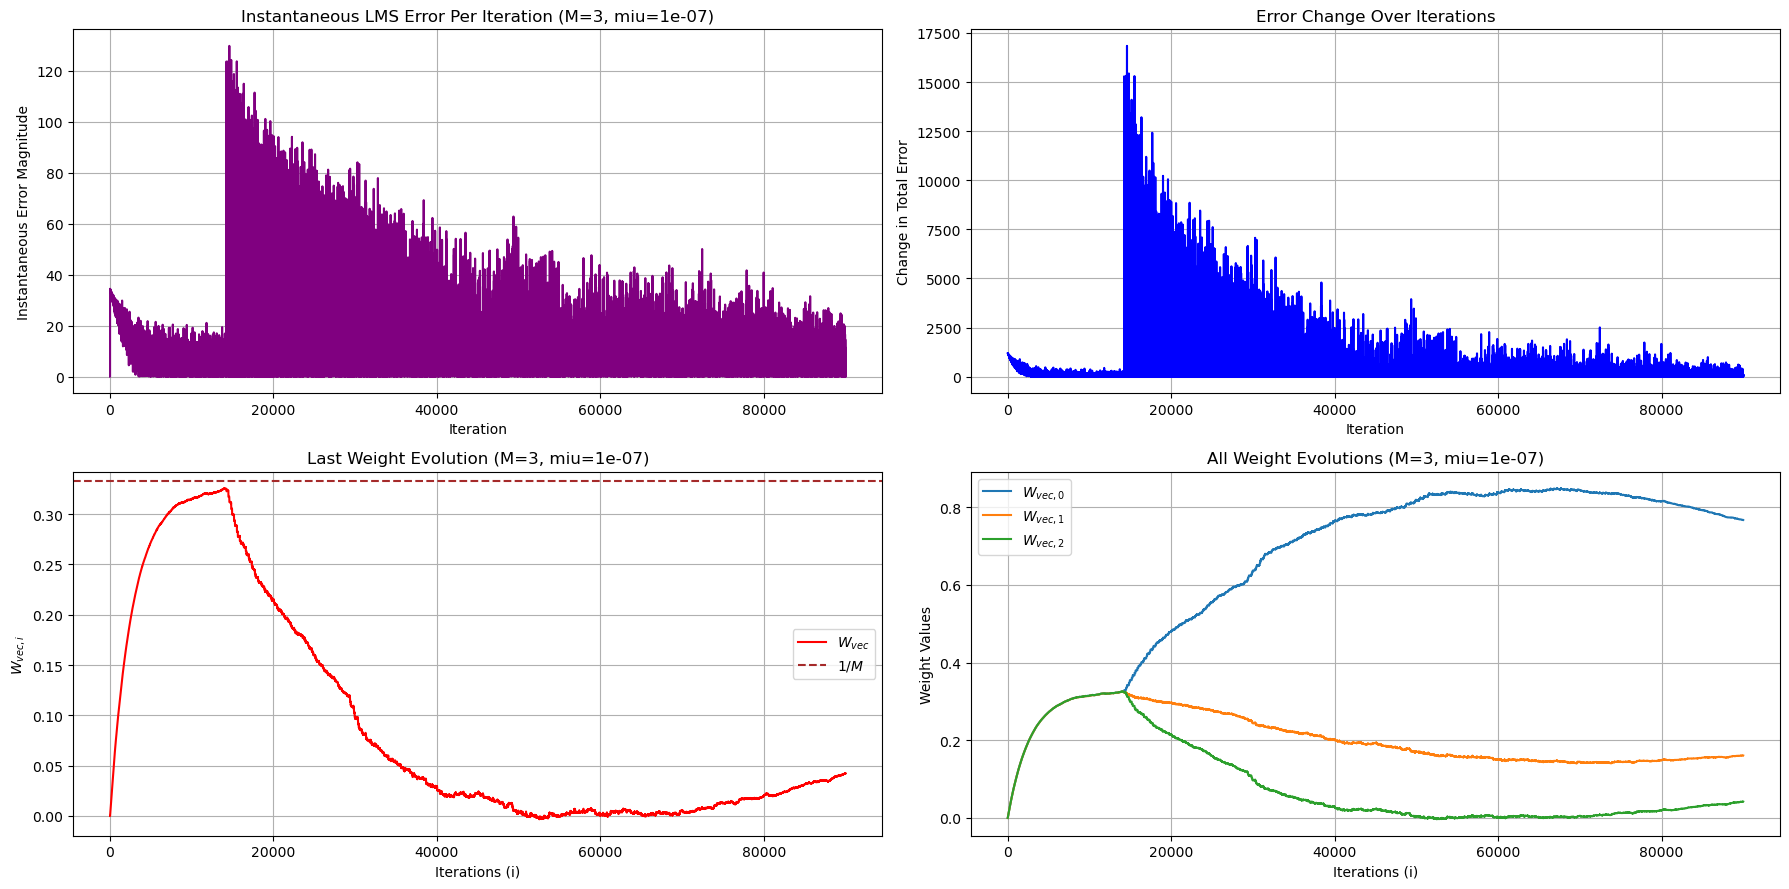

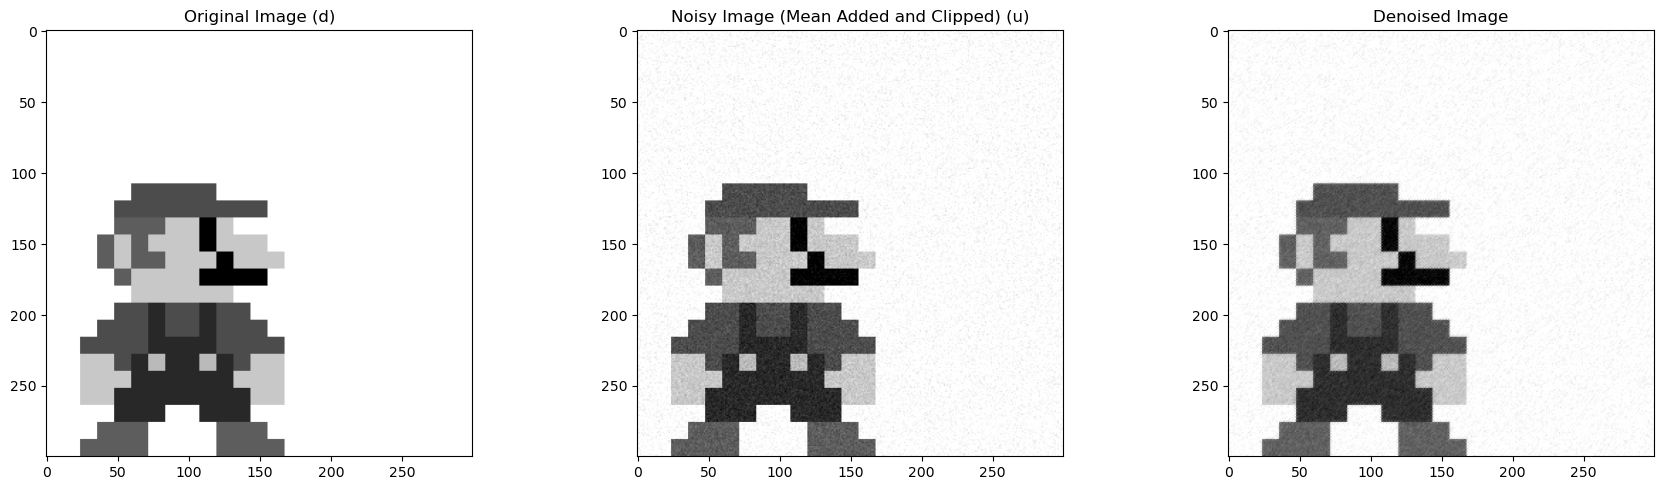

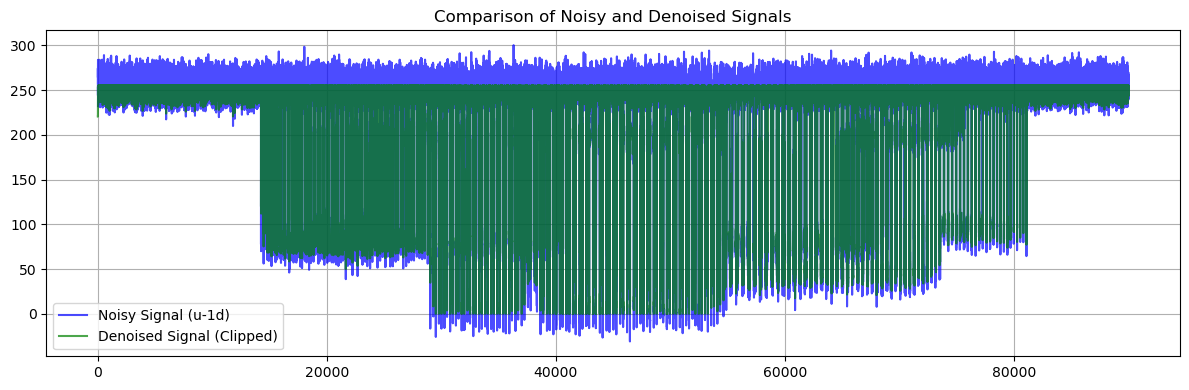

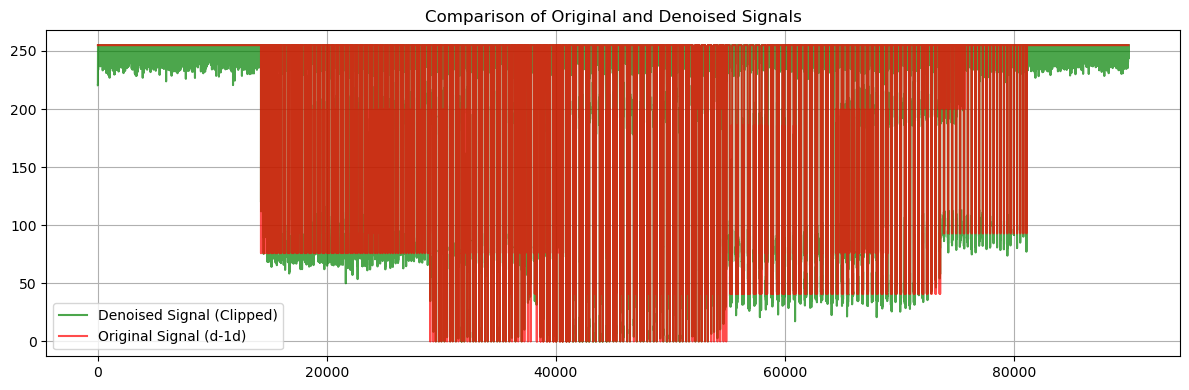

In [30]:
# Set LMS parameters
M = 3  # number of filter coefficients
miu = 1e-7  # step size

# Flatten the noisy and desired signals
u_1d = flatten_zigzag_diagonal(u)  # noisy signal
d_1d = flatten_zigzag_diagonal(d)  # desired signal
totSamples = len(u_1d)  # total samples

# Initialize weights
w = np.zeros((totSamples, M))  # initial weights

newW, LMSErr, error_changes = LMS(u_1d, d_1d, w, M, totSamples, miu) # Apply LMS algorithm
final_w = newW[-1, :]

plt.figure(figsize=(18, 9))

# Plot instantaneous LMS error
plt.subplot(2, 2, 1)
plt.plot(abs(LMSErr), color='purple')
plt.title(f"Instantaneous LMS Error Per Iteration (M={M}, miu={miu})")
plt.xlabel("Iteration")
plt.ylabel("Instantaneous Error Magnitude")
plt.grid(True)

# Plot total error changes
plt.subplot(2, 2, 2)
plt.plot(error_changes, color='blue')
plt.title("Error Change Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Change in Total Error")
plt.grid(True)

# Plot weight evolution for the last weight
plt.subplot(2, 2, 3)
plt.plot(newW[:, M - 1], color='red', label=r'$W_{vec}$')
plt.axhline(y=1/M, color='brown', linestyle='--', label=r'$1/M$')
plt.title(f"Last Weight Evolution (M={M}, miu={miu})")
plt.xlabel("Iterations (i)")
plt.ylabel(r"$W_{vec,i}$")
plt.grid(True)
plt.legend()

# Plot all weight evolutions
plt.subplot(2, 2, 4)
for i in range(M):
    plt.plot(newW[:, i], label=fr'$W_{{vec,{i}}}$')
plt.title(f"All Weight Evolutions (M={M}, miu={miu})")
plt.xlabel("Iterations (i)")
plt.ylabel("Weight Values")
plt.grid(True)
plt.legend()

plt.tight_layout()


# Filter the noisy signal
filtered_image_flattened = np.zeros_like(u_1d)
for i in range(M - 1, totSamples):
    filtered_image_flattened[i] = np.dot(newW[-1, :], u_1d[i - M + 1: i + 1][::-1])

# Reshape filtered signal back to the original image
filtered_image_flattened += np.mean(image)
filtered_image_flattened_cliped = np.clip(filtered_image_flattened, 0, 255)
image_denoised = unflatten_zigzag_diagonal(filtered_image_flattened_cliped, image.shape[0], image.shape[1])

# Display original, noisy, and denoised images
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(d, cmap='gray')
plt.title("Original Image (d)")

plt.subplot(1, 3, 2)
plt.imshow(np.clip(u + np.mean(image), 0, 255), cmap='gray')  # add mean and clip noisy image for better comparison
plt.title("Noisy Image (Mean Added and Clipped) (u)")

plt.subplot(1, 3, 3)
plt.imshow(image_denoised, cmap='gray')
plt.title("Denoised Image")

plt.tight_layout()


# Compare noisy and denoised signals
plt.figure(figsize=(12, 4))
plt.plot(u_1d + np.mean(image), label="Noisy Signal (u-1d)", alpha=0.7, color='blue')
plt.plot(filtered_image_flattened_cliped, label="Denoised Signal (Clipped)", alpha=0.7, color='green')
plt.title("Comparison of Noisy and Denoised Signals")
plt.legend()
plt.grid(True)
plt.tight_layout()


# Compare original and denoised signals
plt.figure(figsize=(12, 4))
plt.plot(filtered_image_flattened_cliped, label="Denoised Signal (Clipped)", alpha=0.7, color='green')
plt.plot(d_1d + np.mean(image), label="Original Signal (d-1d)", alpha=0.7, color='red')
plt.title("Comparison of Original and Denoised Signals")
plt.legend()
plt.grid(True)
plt.tight_layout()


### LMS Algorithm Performance Analysis

This analysis evaluates the LMS algorithm's performance for different filter sizes (`M`) and step sizes (`miu`). Each configuration has three plots:
1. **Weight Evolution**: Shows how weights adjust over time.
2. **Error Changes**: Tracks error change per iteration, indicating convergence speed.
3. **Instantaneous Error**: Displays error at each iteration, showing stability.

#### Configurations and Key Observations:

1. **(M=2, miu=1e-9)**
   - **Weight Evolution**: Smooth, slow convergence.
   - **Error Changes**: High initially, then stabilizes.
   - **Instantaneous Error**: High at first, then stabilizes.
   - **Summary**: Very stable but slow due to low `miu`.

2. **(M=3, miu=1e-6)**
   - **Weight Evolution**: Large oscillations.
   - **Error Changes**: Quick drop, then fluctuates.
   - **Instantaneous Error**: High instability.
   - **Summary**: Fast but unstable due to high `miu`.

3. **(M=8, miu=1e-8)**
   - **Weight Evolution**: Gradual convergence, minor oscillation.
   - **Error Changes**: High start, then steady reduction.
   - **Instantaneous Error**: Smooth reduction.
   - **Summary**: Balanced but slow due to low `miu`.

4. **(M=10, miu=1e-7)**
   - **Weight Evolution**: `w0` and `w1` vary most, others converge to similar values.
   - **Error Changes**: Quick drop, stabilizes.
   - **Instantaneous Error**: Steady decline.
   - **Summary**: Good stability and speed, but redundant weights suggest that a smaller `M` might work as well.

5. **(M=3, miu=1e-7)**
   - **Weight Evolution**: Smooth with minimal oscillations, focused on key weights (`w0`, `w1`, and `w2`).
   - **Error Changes**: Quick initial drop, then stabilizes.
   - **Instantaneous Error**: Gradual, stable reduction.
   - **Summary**: Similar performance to `(M=10, miu=1e-7)`, with fewer weights and less redundancy.

6. **(M=20, miu=1e-9)**
   - **Weight Evolution**: Very slow convergence, high stability.
   - **Error Changes**: Starts high, stabilizes very slowly.
   - **Instantaneous Error**: Consistently high.
   - **Summary**: Stable but too slow due to low `miu` and large `M`.

---

### Conclusion
- **Best Configurations**: `(M=10, miu=1e-7)` and `(M=3, miu=1e-7)` show the best balance between stability and speed.
- **Preferred Configuration**: **`(M=3, miu=1e-7)`**. It achieves similar results to `(M=10, miu=1e-7)` with fewer, essential weights, making it more efficient with less redundancy.

In summary, `(M=3, miu=1e-7)` is the optimal choice for effective, stable, and efficient convergence.

You can find the result file in the uploaded documents.

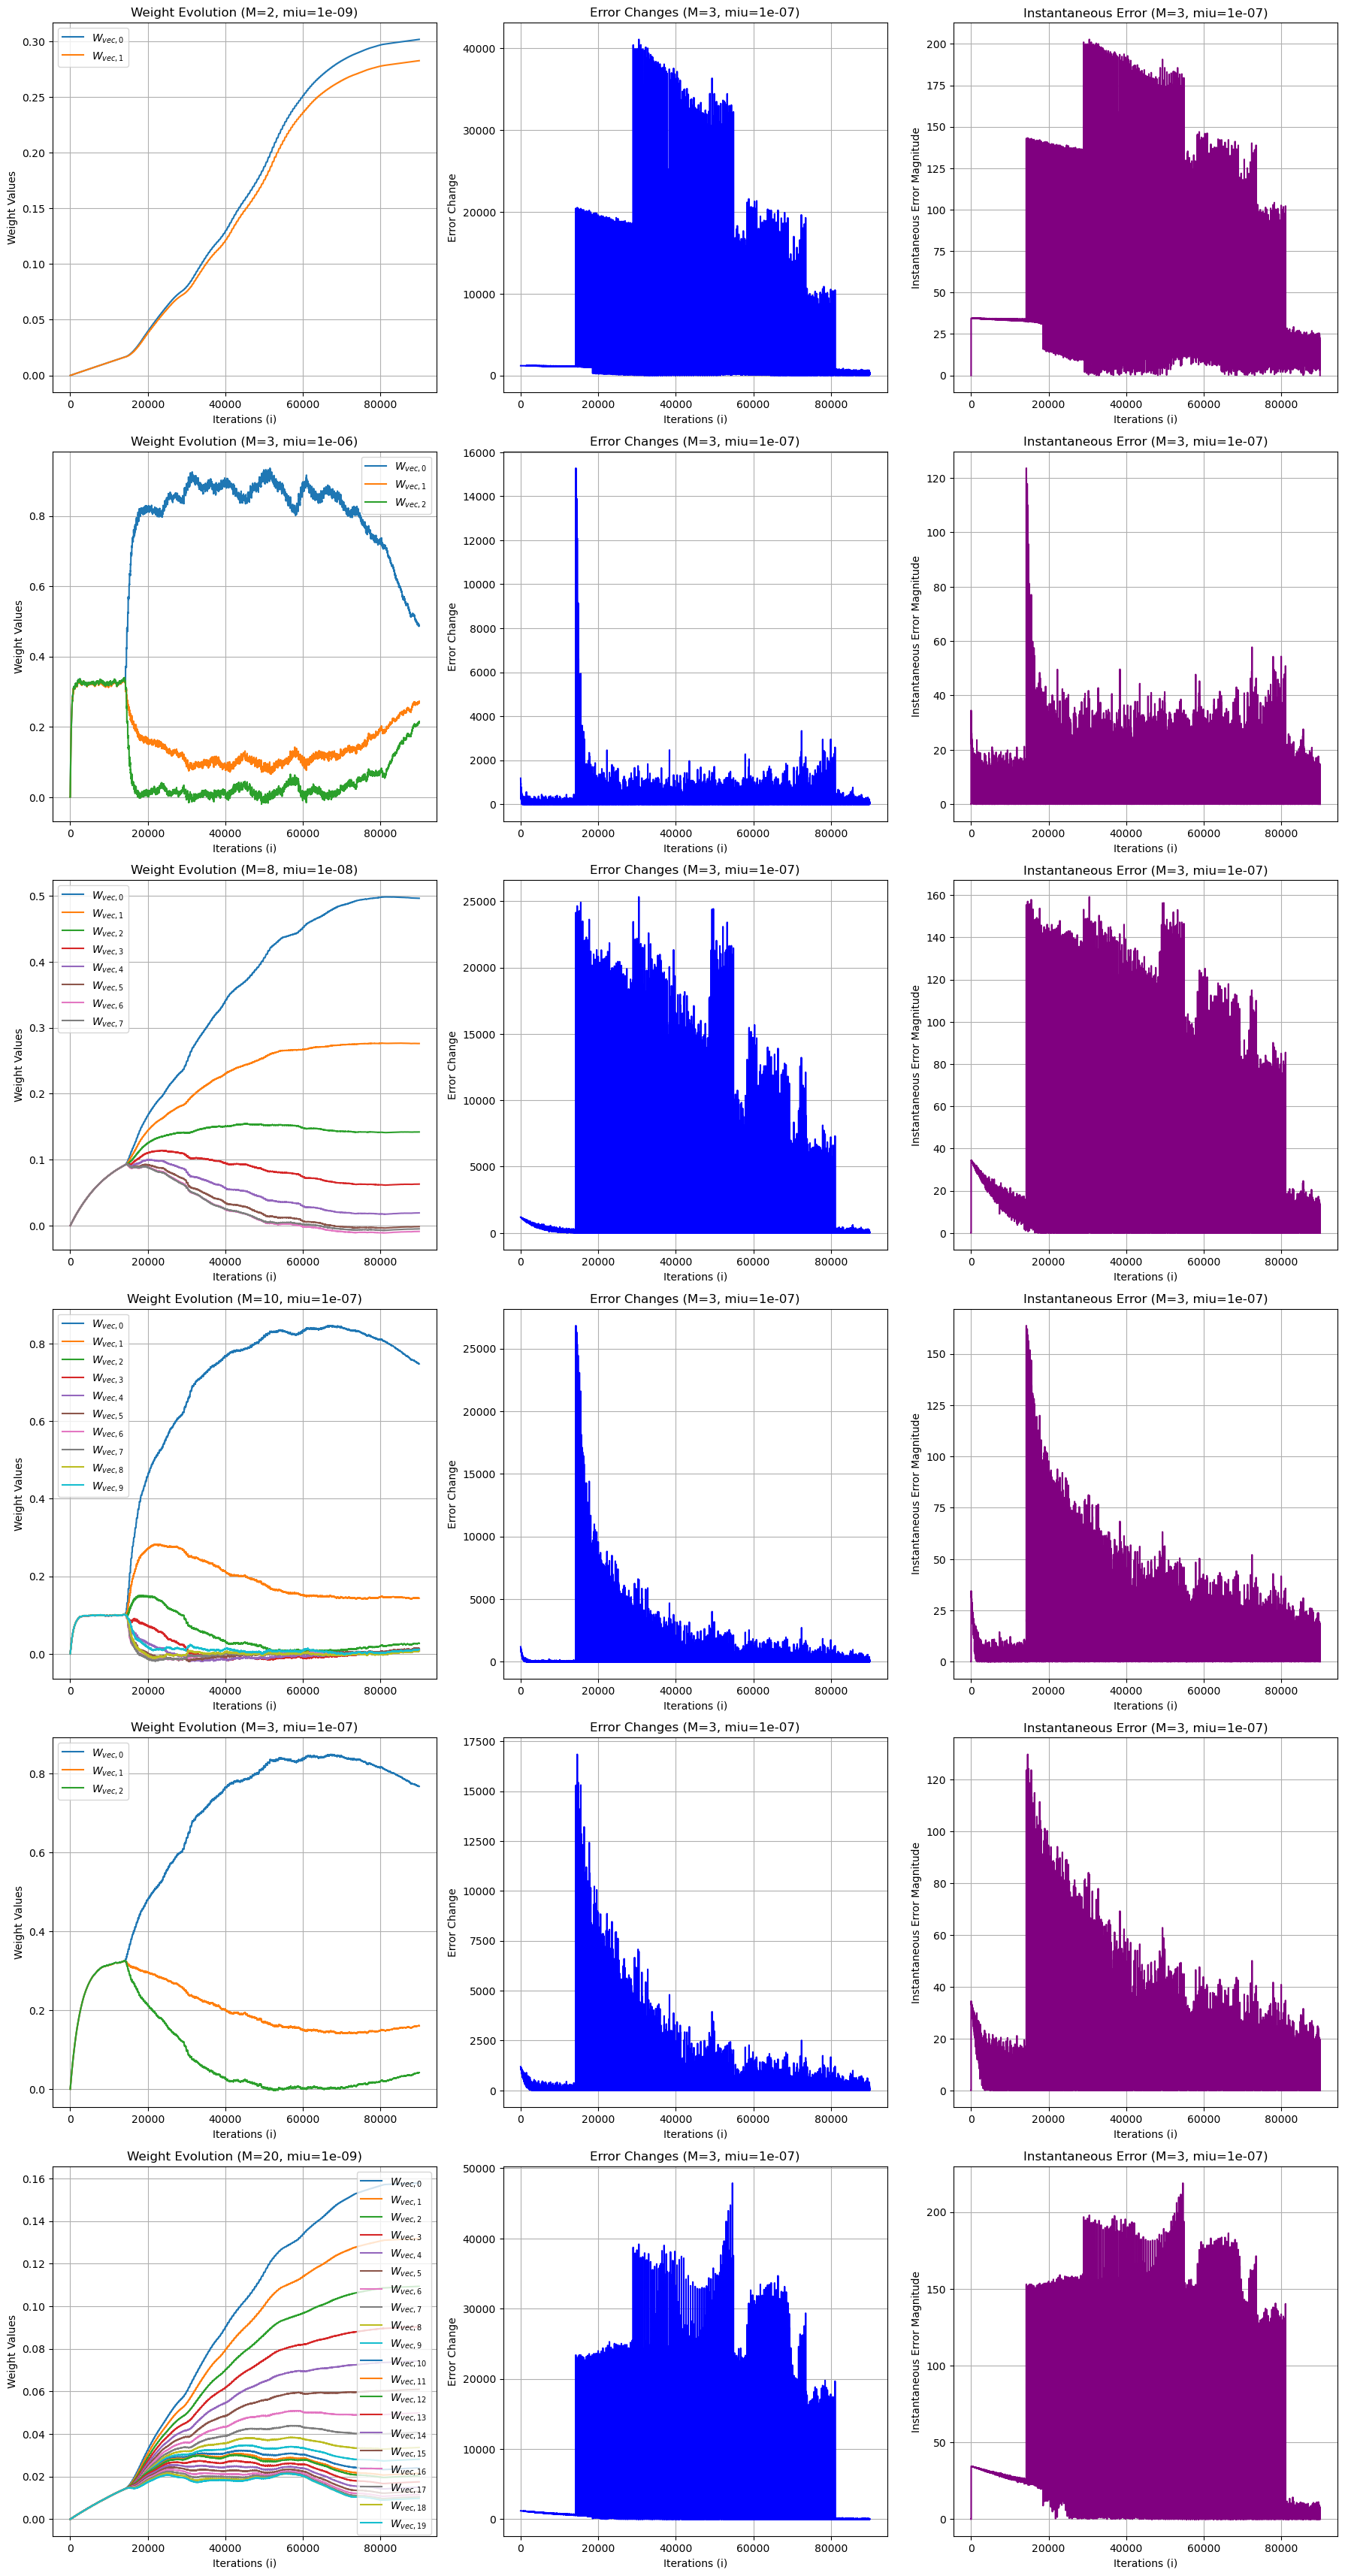

In [36]:
# Configurations for a broader comparison of M and miu
configs = [
    (2, 1e-9),   # Small M with very low miu for stability
    (3, 1e-6),   # Small M with moderately high miu for faster convergence
    (8, 1e-8),   # Larger M with small miu for stability
    (10, 1e-7),  # Larger M with moderate miu, testing balanced convergence
    (3, 1e-7),   # Baseline configuration
    (20, 1e-9),  # Very large M with very low miu for high stability
]

plt.figure(figsize=(18, 35))

for idx, (M_test, miu_test) in enumerate(configs, start=1):
    w = np.zeros((totSamples, M_test))
    newW, evec, error_changes = LMS(u_1d, d_1d, w, M_test, totSamples, miu_test)  # apply LMS algorithm
    
    # Plot weight evolution
    plt.subplot(len(configs), 3, 3 * idx - 2)  # weight evolution
    for i in range(M_test):
        plt.plot(newW[:, i], label=fr'$W_{{vec,{i}}}$')
    plt.title(f'Weight Evolution (M={M_test}, miu={miu_test})')
    plt.xlabel('Iterations (i)')
    plt.ylabel('Weight Values')
    plt.grid(True)
    plt.legend()

    # Plot error changes
    plt.subplot(len(configs), 3, 3 * idx - 1)  # error changes
    plt.plot(error_changes, color='blue')
    plt.title(f'Error Changes (M={M}, miu={miu})')
    plt.xlabel('Iterations (i)')
    plt.ylabel('Error Change')
    plt.grid(True)

    # Plot instantaneous LMS error
    plt.subplot(len(configs), 3, 3 * idx)  # instantaneous error
    plt.plot(abs(evec), color='purple')
    plt.title(f'Instantaneous Error (M={M}, miu={miu})')
    plt.xlabel('Iterations (i)')
    plt.ylabel('Instantaneous Error Magnitude')
    plt.grid(True)

plt.tight_layout()
plt.savefig("lms_plot_comparison_expanded.png")  # save the figure with updated name
plt.show()

### LMS Weight Analysis for Noise Levels 10 and 30

This analysis looks at the mean LMS weights after 30 runs for two different noise levels: 10 and 30.

#### Key Steps:
- Noisy signals are created for noise levels 10 and 30 in each run.
- The LMS algorithm is applied to calculate weights for each run.
- Final weights are saved and averaged across all runs for each noise level.
- The mean weights are compared to see how noise affects the LMS results.

#### Observations from the Plot:
1. **Noise Level 10**:
   - The weights are very different from each other.
   - The first weight (`W_0`) is much higher, and the other weights (`W_1`, `W_2`) are much lower.
   - This shows that the LMS algorithm focuses more on specific features of the signal at low noise.

2. **Noise Level 30**:
   - The weights are close to each other.
   - This happens because the higher noise makes it harder for the LMS algorithm to focus on specific features of the signal.

3. **Comparison**:
   - At **noise level 10**, the weights drop sharply after the first one. This shows the LMS algorithm works well at low noise.
   - At **noise level 30**, the weights are more balanced because the noise makes it harder to distinguish features.

#### Insights:
- Lower noise allows the LMS algorithm to adapt to important signal features, resulting in larger differences between weights.
- Higher noise makes the LMS algorithm distribute weights more evenly, as it struggles to identify clear signal features.

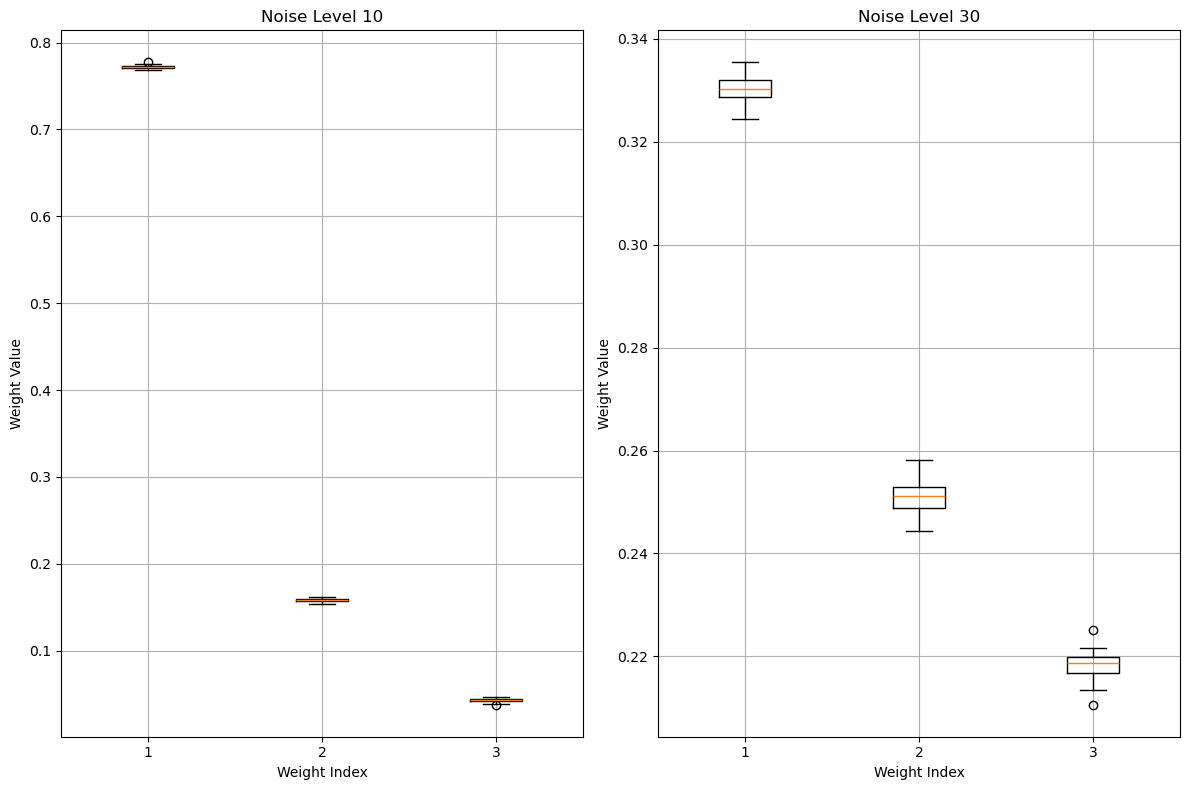

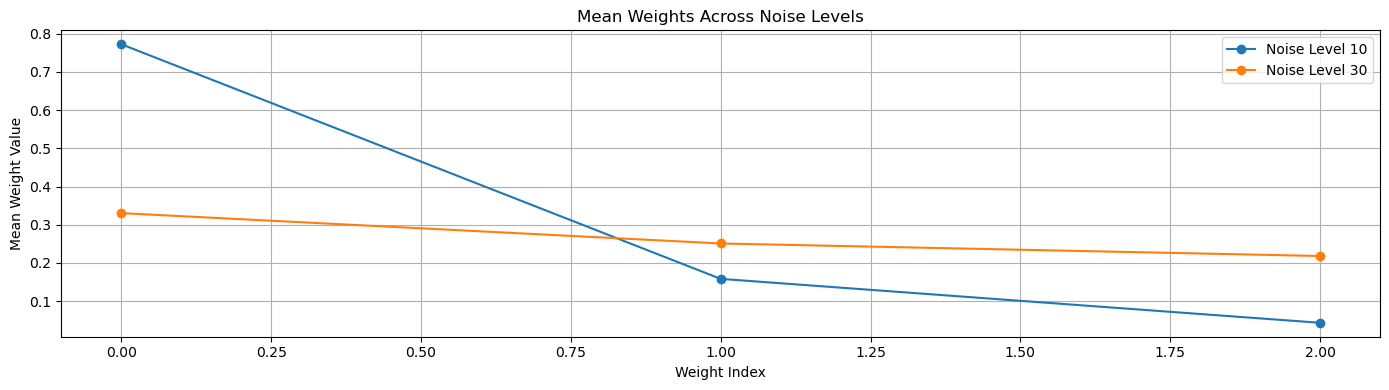


Noise Level: 10
Min Weights: [0.76858198 0.15412718 0.0380144 ]
Max Std Dev: [0.77715201 0.16132502 0.04673802]
Mean Weights: [0.77242138 0.15832979 0.04333272]
Weight Std Dev: [0.00183428 0.00178534 0.00197451]

Noise Level: 30
Min Weights: [0.32437227 0.24435897 0.2106391 ]
Max Std Dev: [0.33538458 0.25812022 0.22504869]
Mean Weights: [0.33036798 0.25092763 0.2181947 ]
Weight Std Dev: [0.00246419 0.00312572 0.00285993]


In [39]:
noise_levels = [10, 30]  # Noise levels to test
runs = 30  # Number of runs
all_weights = {level: np.zeros((runs, M)) for level in noise_levels}  # Store weights for each noise level

# Single loop for runs, generating and processing both noise levels
for run in range(runs):
    noise1 = np.random.normal(0, noise_levels[0], size=image.shape)  # Generate noise for level 10
    noise2 = np.random.normal(0, noise_levels[1], size=image.shape)  # Generate noise for level 30

    # Process noise level 10
    u1 = d + noise1
    u1_1d = flatten_zigzag_diagonal(u1)
    w1 = np.zeros((totSamples, M))
    newW1, _, _ = LMS(u1_1d, d_1d, w1, M, totSamples, miu)
    all_weights[noise_levels[0]][run, :] = newW1[-1, :]  # Store final weights for noise level 10

    # Process noise level 30
    u2 = d + noise2
    u2_1d = flatten_zigzag_diagonal(u2)
    w2 = np.zeros((totSamples, M))
    newW2, _, _ = LMS(u2_1d, d_1d, w2, M, totSamples, miu)
    all_weights[noise_levels[1]][run, :] = newW2[-1, :]  # Store final weights for noise level 30

# Plot the box-whisker plots for each noise level
plt.figure(figsize=(12, 8))
for idx, noise_level in enumerate(noise_levels, start=1):
    plt.subplot(1, len(noise_levels), idx)
    plt.boxplot(all_weights[noise_level])
    plt.title(f"Noise Level {noise_level}")
    plt.xlabel("Weight Index")
    plt.ylabel("Weight Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Compare mean weights across noise levels
plt.figure(figsize=(14, 4))
for noise_level in noise_levels:
    mean_weights = np.mean(all_weights[noise_level], axis=0)  # Compute mean weights for this noise level
    plt.plot(mean_weights, label=f"Noise Level {noise_level}", marker='o')

plt.title("Mean Weights Across Noise Levels")
plt.xlabel("Weight Index")
plt.ylabel("Mean Weight Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output weight statistics for each noise level
for noise_level in noise_levels:
    print(f"\nNoise Level: {noise_level}")
    print(f"Min Weights: {np.min(all_weights[noise_level], axis=0)}")
    print(f"Max Std Dev: {np.max(all_weights[noise_level], axis=0)}")
    print(f"Mean Weights: {np.mean(all_weights[noise_level], axis=0)}")
    print(f"Weight Std Dev: {np.std(all_weights[noise_level], axis=0)}")

### Function: Applying LMS Algorithm to Denoise an Image

This function allows testing the LMS algorithm on various images with customizable parameters. It takes a grayscale image, adds Gaussian noise, and applies the LMS algorithm to reduce the noise. It also provides optional visualizations for analyzing the results.

**Parameters:**
- **`file_path`**: Path to the input image file.
- **`noise_level`**: Standard deviation of Gaussian noise to be added.
- **`M`**: Number of filter coefficients for the LMS algorithm.
- **`miu`**: Step size for weight updates in the LMS algorithm.
- **`W`**: Pre-computed weights (optional, defaults to 0).
- **`use_another_w`**: If `True`, uses the provided weights (`W`) instead of calculating new ones.
- **`output_print`**: If `True`, generates plots and visualizations for error analysis and signal comparisons.

**Outputs:**
1. A denoised version of the input image.
2. Optional visualizations, including:
   - LMS error progression and weight evolution.
   - Original, noisy, and denoised images.
   - Comparisons between noisy, denoised, and original signals.

This function simplifies experimentation with the LMS algorithm and provides comprehensive visual feedback for understanding its effectiveness.

In [42]:
def lms_over_file(file_path, noise_level, M, miu, W=0, use_another_w=False, output_print=False):
  
    image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)  # load grayscale image
    image = cv.resize(image, (300, 300))  # resize to 300x300
    d = image - np.mean(image)  # create zero-mean desired image
    noise = np.random.normal(0, noise_level, size=image.shape)  # generate Gaussian noise
    u = d + noise  # create noisy image
    u_1d = flatten_zigzag_diagonal(u)  # flatten noisy image
    d_1d = flatten_zigzag_diagonal(d)  # flatten desired image
    totSamples = len(u_1d)  # total number of samples
    w = np.zeros((totSamples, M))  # initialize weights
    newW, LMSErr, error_changes = LMS(u_1d, d_1d, w, M, totSamples, miu)  # apply LMS algorithm
    
    if not use_another_w:
        W = newW[-1,:]
        
    # filter the noisy signal
    filtered_image_flattened = np.zeros_like(u_1d)
    for i in range(M - 1, totSamples):
        filtered_image_flattened[i] = np.dot(W, u_1d[i - M + 1: i + 1][::-1])
    filtered_image_flattened += np.mean(image)  # restore mean
    filtered_image_flattened_cliped = np.clip(filtered_image_flattened, 0, 255)  # clip values
    image_denoised = unflatten_zigzag_diagonal(filtered_image_flattened_cliped, image.shape[0], image.shape[1])

    if output_print:  # if output visualization is required

        plt.figure(figsize=(14, 6))  # create a grid for error and weight plots

        if not use_another_w:
            # plot instantaneous LMS error
            plt.subplot(2, 2, 1)
            plt.plot(abs(LMSErr), color='purple')
            plt.title(f"Instantaneous LMS Error Per Iteration (M={M}, miu={miu})")
            plt.xlabel("Iteration")
            plt.ylabel("Instantaneous Error Magnitude")
            plt.grid(True)
            
            # plot total error changes
            plt.subplot(2, 2, 2)
            plt.plot(error_changes, color='blue')
            plt.title("Error Change Over Iterations")
            plt.xlabel("Iteration")
            plt.ylabel("Change in Total Error")
            plt.grid(True)
        
        # plot weight evolution for the last weight
        plt.subplot(2, 2, 3)
        plt.plot(newW[:, M - 1], color='red', label=r'$W_{vec}$')
        plt.axhline(y=1/M, color='brown', linestyle='--', label=r'$1/M$')
        plt.title(f"Last Weight Evolution (M={M}, miu={miu})")
        plt.xlabel("Iterations (i)")
        plt.ylabel(r"$W_{vec,i}$")
        plt.grid(True)
        plt.legend()
        
        # plot all weight evolutions
        plt.subplot(2, 2, 4)
        for i in range(M):
            plt.plot(newW[:, i])
        plt.title(f"All Weight Evolutions (M={M}, miu={miu})")
        plt.xlabel("Iterations (i)")
        plt.ylabel("Weight Values")
        plt.grid(True)
        
        plt.tight_layout()

        # display original, noisy, and denoised images
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(d, cmap='gray')
        plt.title("Original Image (d)")
        
        plt.subplot(1, 3, 2)
        plt.imshow(np.clip(u + np.mean(image), 0, 255), cmap='gray')  # add mean to restore original intensity range and clip values for comparison
        plt.title("Noisy Image (Mean Added and Clipped) (u)")
        
        plt.subplot(1, 3, 3)
        plt.imshow(image_denoised, cmap='gray')
        plt.title("Denoised Image")
        
        plt.tight_layout()
        
        # compare noisy and denoised signals
        plt.figure(figsize=(12, 4))
        plt.plot(u_1d + np.mean(image), label="Noisy Signal (u-1d)", alpha=0.7, color='blue')
        plt.plot(filtered_image_flattened_cliped, label="Denoised Signal (Clipped)", alpha=0.7, color='green')
        plt.title("Comparison of Noisy and Denoised Signals")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # compare original and denoised signals
        plt.figure(figsize=(12, 4))
        plt.plot(filtered_image_flattened_cliped, label="Denoised Signal (Clipped)", alpha=0.7, color='green')
        plt.plot(d_1d + np.mean(image), label="Original Signal (d-1d)", alpha=0.7, color='red')
        plt.title("Comparison of Original and Denoised Signals")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

### LMS Algorithm with Pre-computed Tap Weights for Denoising a New Image

Now I use pre-computed tap weights (from a previous LMS output) to denoise a new image with the same noise level and image size. By applying pre-learned weights (`W`), we can verify if the new image is also denoised under similar conditions.

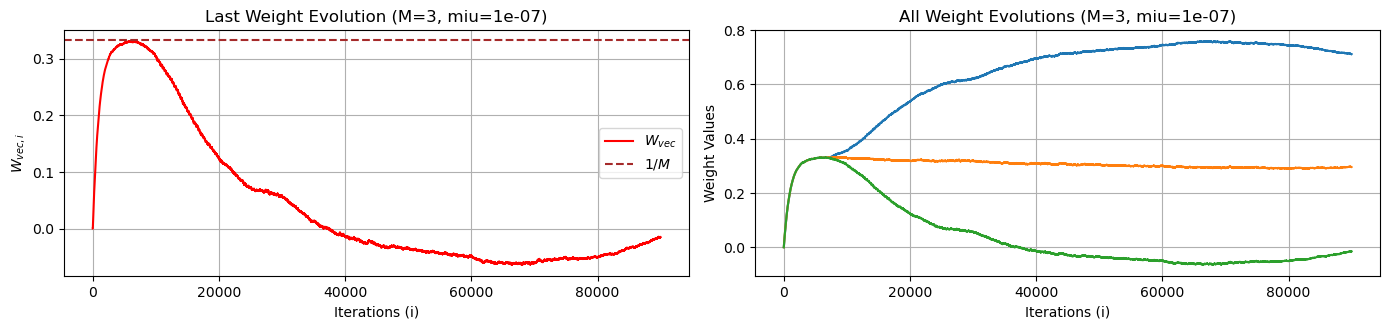

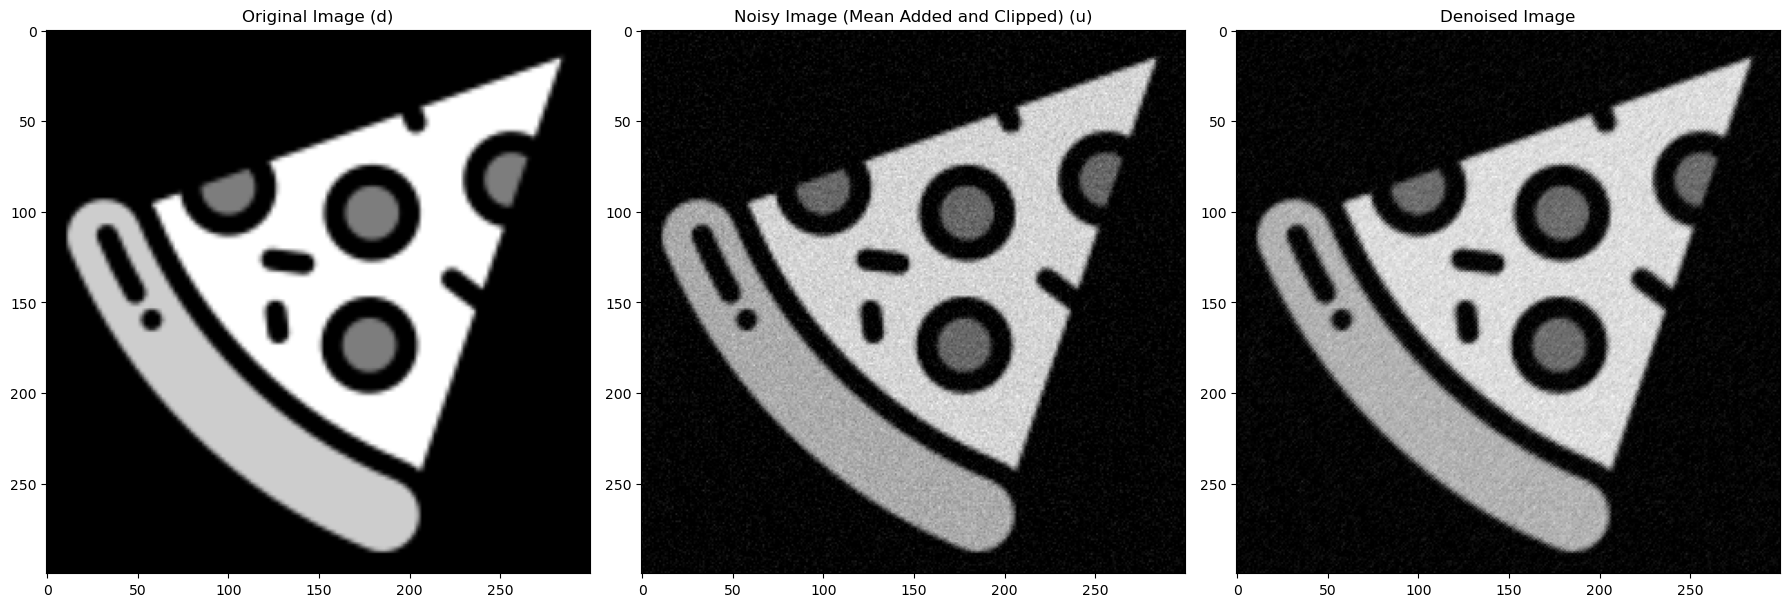

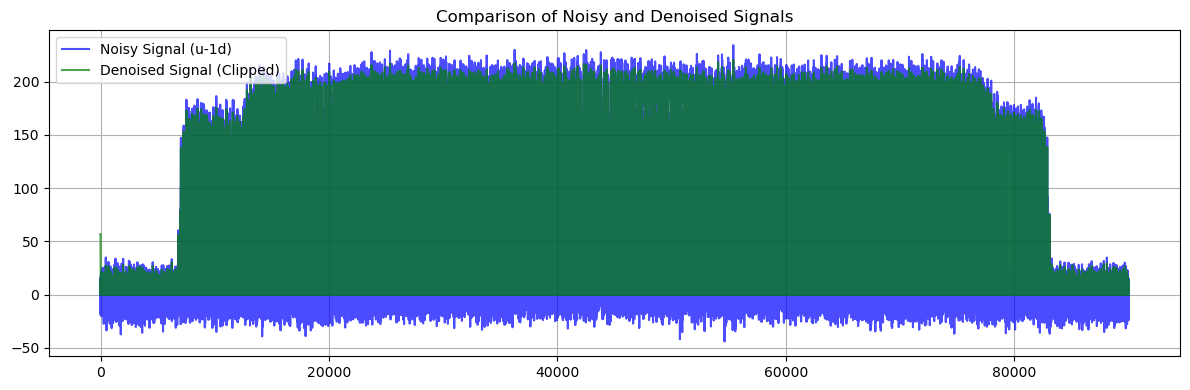

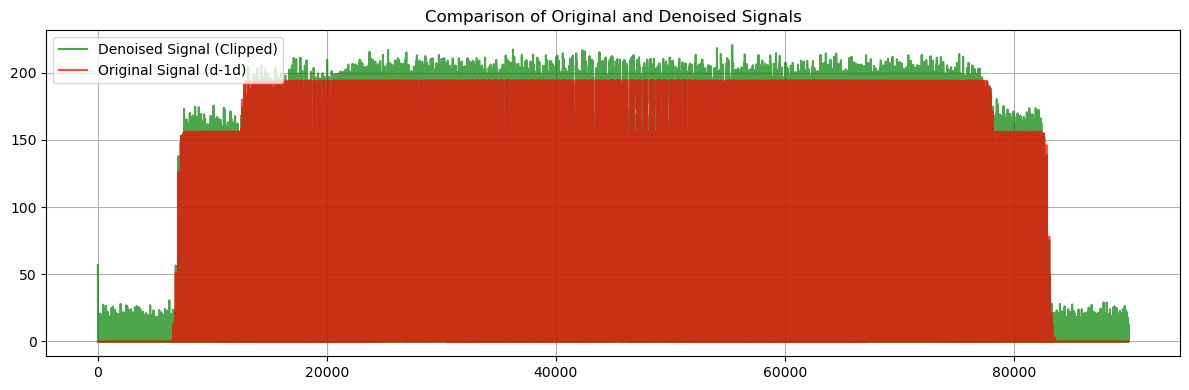

In [45]:
lms_over_file(file_path='pizza.png', noise_level=10, M=M, miu=miu, W=final_w, use_another_w=True, output_print=True)

### Applying LMS on a Solid Gray Image with Noise

In this experiment, I created a solid gray image where all pixel values are 150. To test the LMS algorithm:

1. **Solid Image Creation**: A solid gray image with all pixel values set to 150 was generated.
2. **Noise Addition**: Gaussian noise (mean=0, standard deviation=20) was added to the image, creating a noisy image. The noise values mostly range between -90 and 90.
3. **LMS Application**: The LMS algorithm was applied with the following parameters:
   - **Filter Size (M)**: 30
   - **Step Size (miu)**: 1e-9
4. **Observation**: The denoised image demonstrates that the algorithm effectively reduces noise. Increasing the value of **M** would further improve the denoising performance, as a larger filter size enhances noise reduction.

This showcases the capability of the LMS algorithm in handling structured images with uniform pixel values.

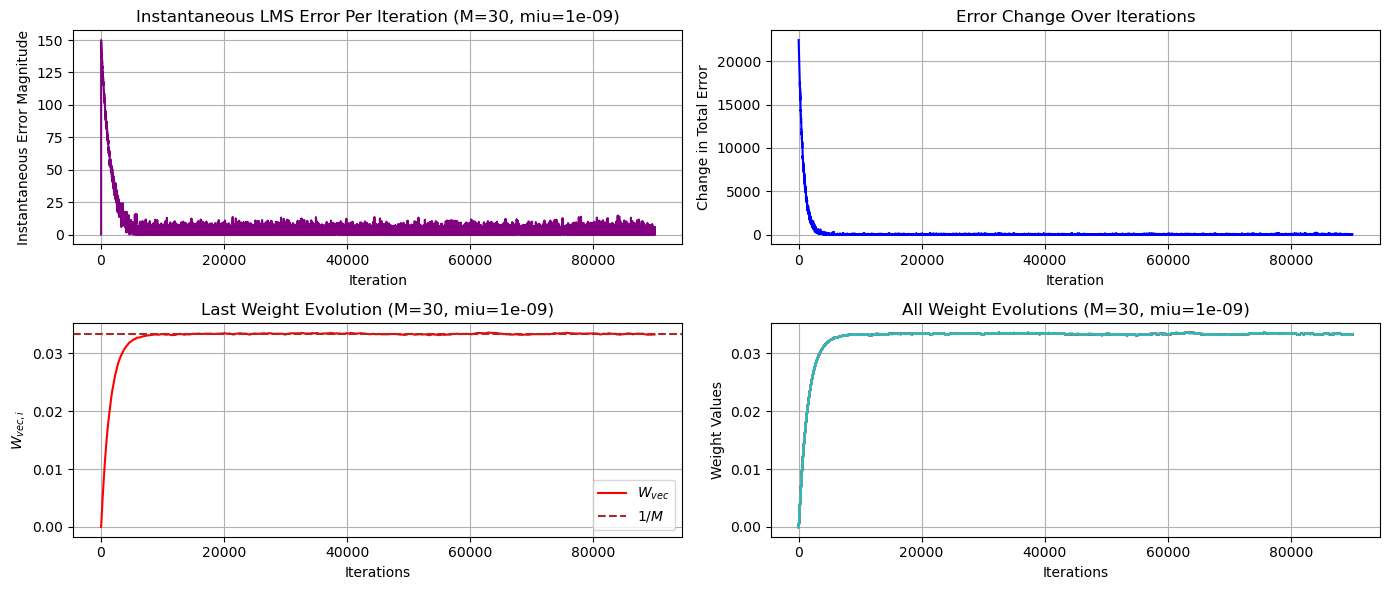

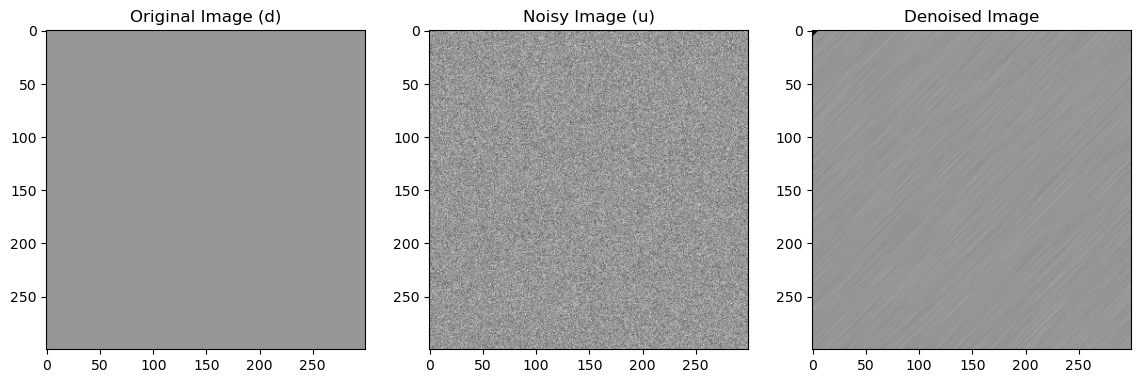

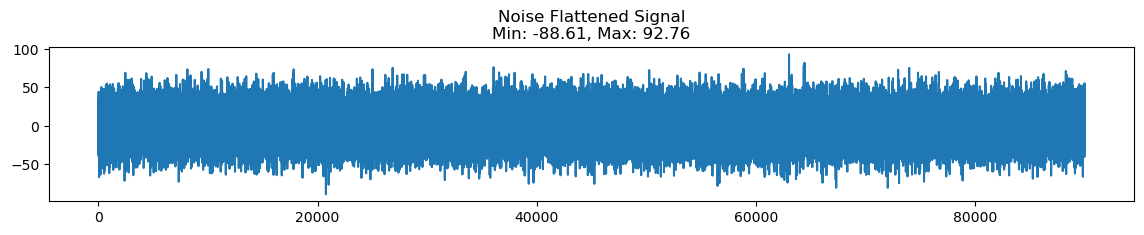

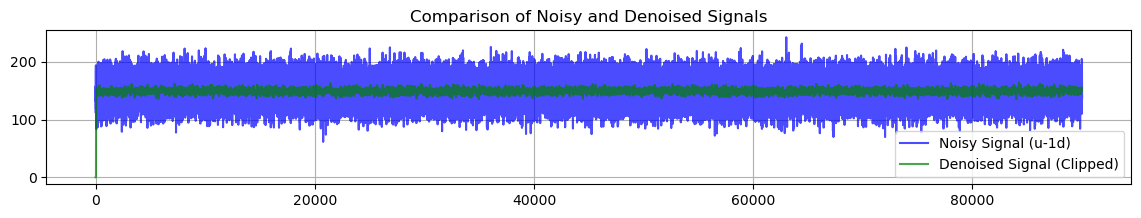

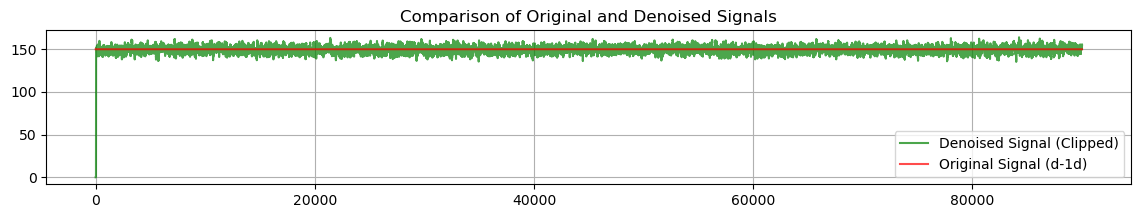

In [48]:
d = np.full((300, 300), 150, dtype=np.uint8)  # create solid image with pixel values 150
noise = np.random.normal(0, 20, size=d.shape)  # generate Gaussian noise
u = d + noise  # add noise to create noisy image

u_1d = flatten_zigzag_diagonal(u)  # flatten noisy image
d_1d = flatten_zigzag_diagonal(d)  # flatten original solid image
totSamples = len(u_1d)  # total number of samples

M = 30  # filter size
miu = 1e-9  # step size
w = np.zeros((totSamples, M))  # initialize LMS weights
newW, LMSErr, error_changes = LMS(u_1d, d_1d, w, M, totSamples, miu)  # apply LMS algorithm

filtered_image_flattened = np.zeros_like(u_1d)  # initialize filtered signal
for i in range(M - 1, totSamples):
    filtered_image_flattened[i] = np.dot(newW[-1, :], u_1d[i - M + 1: i + 1][::-1])  # apply filter
filtered_image_flattened_cliped = np.clip(filtered_image_flattened, 0, 255)  # clip to valid range
image_denoised = unflatten_zigzag_diagonal(filtered_image_flattened_cliped, d.shape[0], d.shape[1])  # reshape to 2D

plt.figure(figsize=(14, 6))  # start plotting errors and weight evolutions

plt.subplot(2, 2, 1)
plt.plot(abs(LMSErr), color='purple')  # plot instantaneous LMS error
plt.title(f"Instantaneous LMS Error Per Iteration (M={M}, miu={miu})")
plt.xlabel("Iteration")
plt.ylabel("Instantaneous Error Magnitude")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(error_changes, color='blue')  # plot error changes
plt.title("Error Change Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Change in Total Error")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(newW[:, M - 1], color='red', label=r'$W_{vec}$')  # last weight evolution
plt.axhline(y=1 / M, color='brown', linestyle='--', label=r'$1/M$')  # reference value
plt.title(f"Last Weight Evolution (M={M}, miu={miu})")
plt.xlabel("Iterations")
plt.ylabel(r"$W_{vec,i}$")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
for i in range(M):
    plt.plot(newW[:, i])  # plot all weight evolutions
plt.title(f"All Weight Evolutions (M={M}, miu={miu})")
plt.xlabel("Iterations")
plt.ylabel("Weight Values")
plt.grid(True)

plt.tight_layout()  # adjust layout for better visualization

plt.figure(figsize=(14, 6))  # plot original, noisy, and denoised images
plt.subplot(1, 3, 1)
plt.imshow(d, cmap='gray', vmin=0, vmax=255)  # original image
plt.title("Original Image (d)")

plt.subplot(1, 3, 2)
plt.imshow(u, cmap='gray', vmin=0, vmax=255)  # noisy image
plt.title("Noisy Image (u)")

plt.subplot(1, 3, 3)
plt.imshow(image_denoised, cmap='gray', vmin=0, vmax=255)  # denoised image
plt.title("Denoised Image")

plt.figure(figsize=(14, 2))  # plot noise signal
plt.plot(flatten_zigzag_diagonal(noise))  # noise in flattened form
plt.title(f'Noise Flattened Signal\nMin: {noise.min():.2f}, Max: {noise.max():.2f}')

plt.figure(figsize=(14, 2))  # compare noisy and denoised signals
plt.plot(u_1d, label="Noisy Signal (u-1d)", alpha=0.7, color='blue')
plt.plot(filtered_image_flattened_cliped, label="Denoised Signal (Clipped)", alpha=0.7, color='green')
plt.title("Comparison of Noisy and Denoised Signals")
plt.legend()
plt.grid(True)

plt.figure(figsize=(14, 2))  # compare original and denoised signals
plt.plot(filtered_image_flattened_cliped, label="Denoised Signal (Clipped)", alpha=0.7, color='green')
plt.plot(d_1d, label="Original Signal (d-1d)", alpha=0.7, color='red')
plt.title("Comparison of Original and Denoised Signals")
plt.legend()
plt.grid(True)

### Applying LMS on a Diagonal Gradient Image

Following the previous example, I used the LMS algorithm on a diagonal gradient image, where pixel values increase linearly along the diagonal zigzag pattern. 

The output is similar to the solid gray image experiment, as the diagonal gradient aligns with the linear nature of the flattening style. Based on this result, I plan to test a left-to-right gradient (non-linear in the context of diagonal flattening) to see how the output changes.

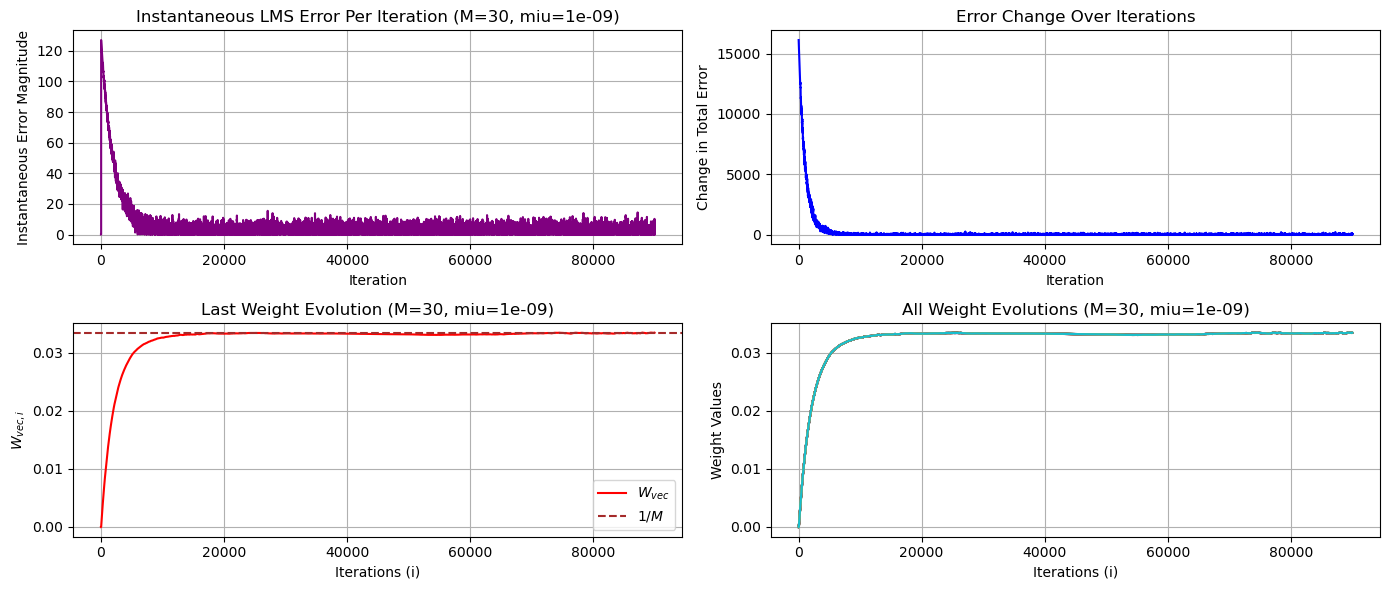

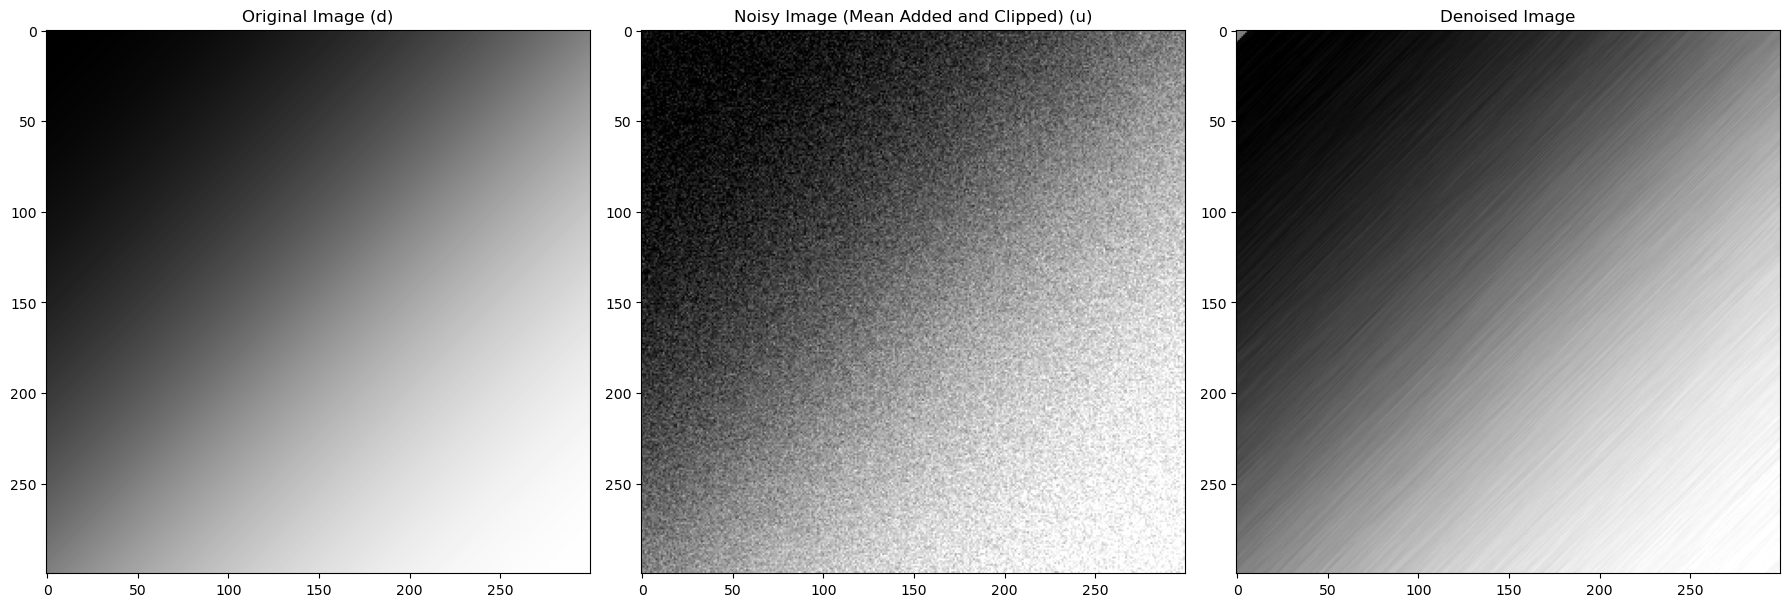

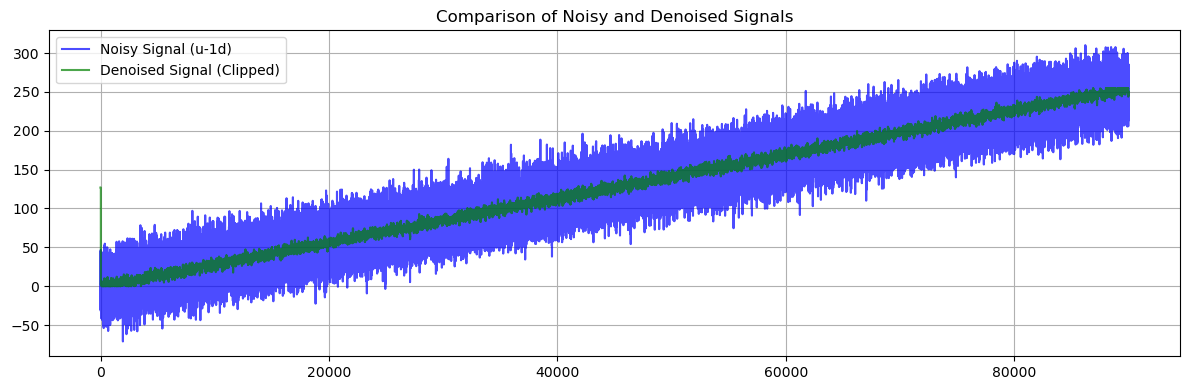

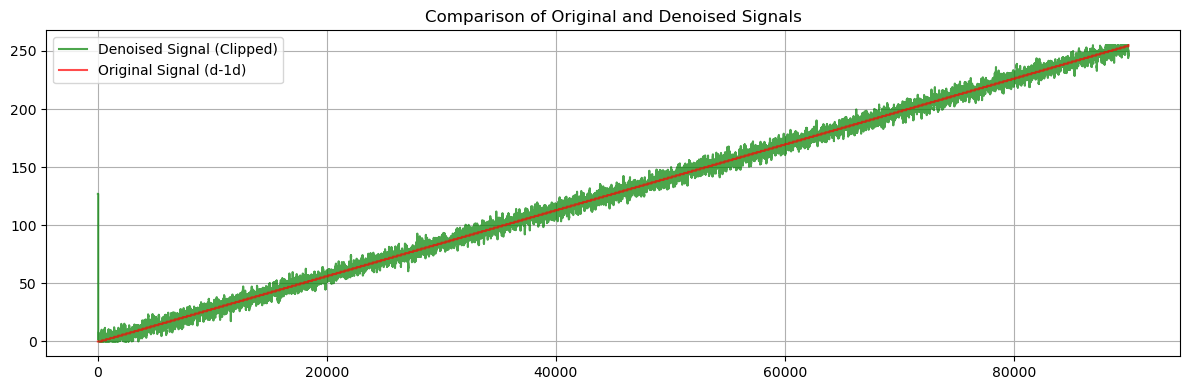

In [51]:
# Create a diagonal gradient image, where pixel values increase linearly along the zigzag diagonal pattern
image = np.array(unflatten_zigzag_diagonal(np.linspace(0, 255, 90000, dtype=np.uint8), 300, 300))
cv.imwrite("diagonal_gradient_image.png", image)
lms_over_file(file_path='diagonal_gradient_image.png', noise_level=20, M=30, miu=1e-9, output_print=True)

### Applying LMS on a Vertical Gradient Image

Following the diagonal gradient example, I tested the LMS algorithm on a **vertical gradient image**, where pixel values gradually increase from top (black) to bottom (white).

- **Vertical Gradient**: A gradient was created with values ranging from 0 to 255 from top to bottom.
- **Parameters**:
  - **Filter Size (M)**: 6
  - **Step Size (miu)**: 1e-8
  - **Noise Level**: Gaussian noise with a standard deviation of 10.
- **Observation**: The result is not as good as the diagonal gradient or solid images. Despite the lower noise level, the output is mostly similar or a little bit better than previously denoised images.


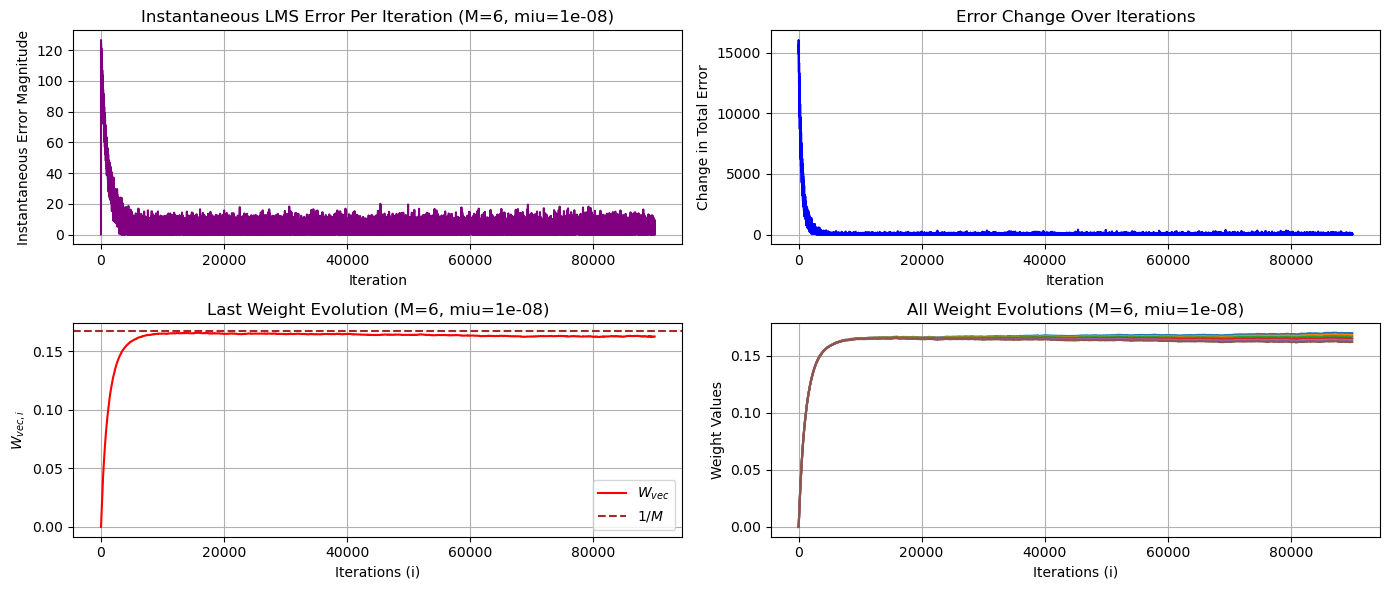

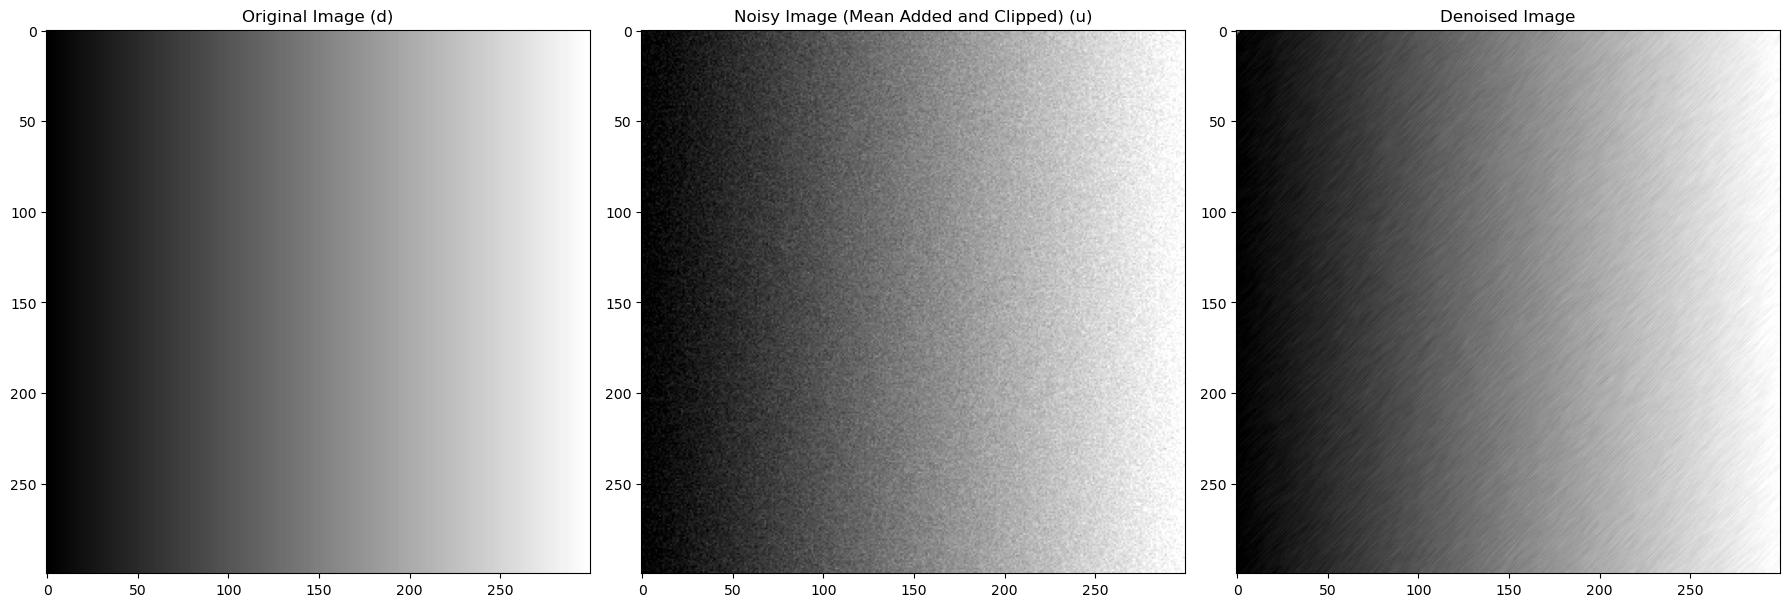

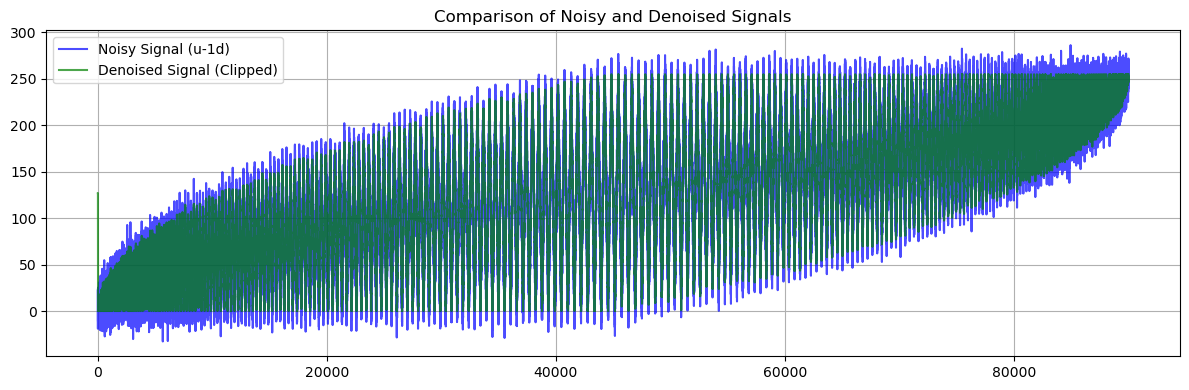

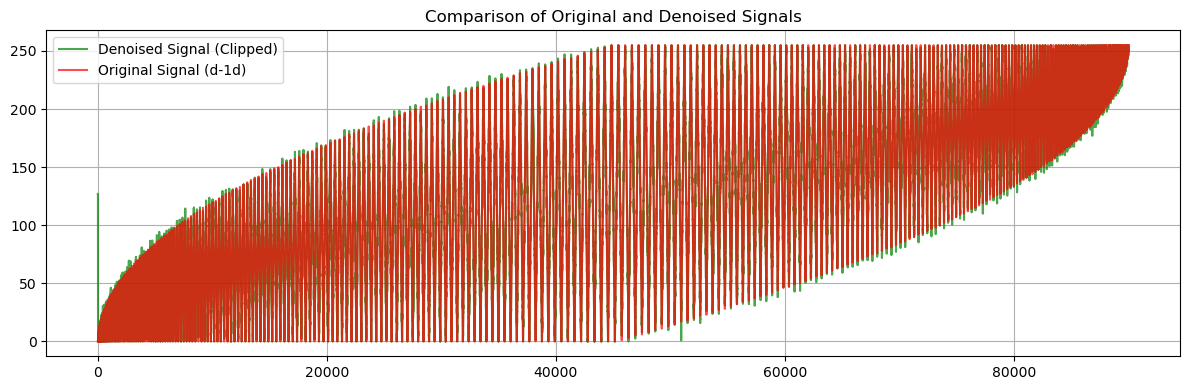

In [54]:
# Create a vertical gradient image, where pixel values increase linearly from left to right
image = np.tile(np.linspace(0, 255, 300, dtype=np.uint8), (300, 1))
cv.imwrite("gradient_image.png", image)
lms_over_file(file_path='gradient_image.png', noise_level=10, M=6, miu=1e-8, output_print=True)

### Function: `plot_signal`

This function creates plots to analyze the LMS algorithm's performance in filtering a noisy signal. 

#### Features:
1. **Error and Weight Analysis**:
   - Instantaneous error during filtering.
   - Changes in total error to track convergence.
   - Evolution of filter weights over time.

2. **Signal Plots**:
   - Original signal (clean).
   - Noise added to the signal.
   - Noisy signal (original + noise).
   - Filtered signal after applying LMS.

3. **Signal Comparisons**:
   - Compare noisy vs. filtered signals.
   - Compare original vs. filtered signals.
   - Zoomed-in views for closer inspection.

In [57]:
def plot_signal():

    plt.figure(figsize=(18, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(abs(LMSErr), color='purple')  # instantaneous error
    plt.title(f"Instantaneous LMS Error Per Iteration (M={M}, miu={miu})")
    plt.xlabel("Iteration")
    plt.ylabel("Instantaneous Error Magnitude")
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(error_changes, color='blue')  # error changes
    plt.title("Error Change Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Change in Total Error")
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(newW[:, M - 1], color='red', label=r'$W_{vec}$')  # last weight evolution
    plt.axhline(y=1 / M, color='brown', linestyle='--', label=r'$1/M$')
    plt.title(f"Last Weight Evolution (M={M}, miu={miu})")
    plt.xlabel("Iterations")
    plt.ylabel(r"$W_{vec,i}$")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    for i in range(M):
        plt.plot(newW[:, i])  # all weight evolutions
    plt.title(f"All Weight Evolutions (M={M}, miu={miu})")
    plt.xlabel("Iterations")
    plt.ylabel("Weight Values")
    plt.grid(True)
    
    plt.tight_layout()
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(t, signal, label='Original Signal')  # plot original signal
    plt.title('Original Signal')
    plt.grid(True)
    
    plt.subplot(4, 1, 2)
    plt.plot(t, noise, label='Noise Signal', alpha=0.7)  # plot noise
    plt.title(f'Noise Signal\nMin: {noise.min():.2f}, Max: {noise.max():.2f}')
    plt.grid(True)
    
    plt.subplot(4, 1, 3)
    plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)  # plot noisy signal
    plt.title('Noisy Signal')
    plt.grid(True)
    
    plt.subplot(4, 1, 4)
    plt.plot(t, filtered_signal, label='Filtered Signal', color='green')  # plot filtered signal
    plt.title('Filtered Signal')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 3))
    plt.plot(t, d, label='Original Signal (d)', color='red', alpha=0.8)  # compare original and filtered
    plt.plot(t, filtered_signal, label='Filtered Signal', color='green', alpha=0.8)
    plt.legend()
    plt.title("Comparison of Original and Filtered Signals")
    plt.grid(True)
    
    plt.figure(figsize=(14, 3))
    plt.plot(t, u, label='Noisy Signal (u)', color='red', alpha=0.7)  # compare noisy and filtered
    plt.plot(t, filtered_signal, label='Filtered Signal', color='green', alpha=0.7)
    plt.legend()
    plt.title("Comparison of Original and Filtered Signals")
    plt.grid(True)
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t, d, label='Original Signal (d)', color='red', alpha=0.8)  # zoomed comparison original vs filtered
    plt.plot(t, filtered_signal, label='Filtered Signal', color='green', alpha=0.8)
    plt.xlim(3.5, 4.5)  # zoom in
    plt.legend()
    plt.title("Zoomed-in Comparison of Original and Filtered Signals")
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(t, u, label='Noisy Signal (u)', color='red', alpha=0.7)  # zoomed comparison noisy vs filtered
    plt.plot(t, filtered_signal, label='Filtered Signal', color='green', alpha=0.7)
    plt.legend()
    plt.xlim(3.5, 4.5)  # zoom in
    plt.title("Zoomed-in Comparison of Noisy and Filtered Signals")
    plt.grid(True)
    
    plt.show()

### Applying LMS on a Signal with Combined Sine Waves

In this test, I applied the LMS algorithm to a **signal** made by combining sine waves with added noise.

- **Signal Description**:
  - The signal is a mix of three sine waves:
    - sin(2πt) (basic frequency),
    - 0.5 * sin(2π * 3t) (third harmonic),
    - 0.25 * sin(2π * 5t) (fifth harmonic).
  - Small Gaussian noise (standard deviation = 0.03) was added to make it more realistic.
- **Noise**: Gaussian noise with a standard deviation of 0.3 was added to create the noisy version of the signal.
- **Parameters**:
  - **Filter Size (M)**: 5
  - **Step Size (miu)**: 5e-4
- **Observation**:
  - The filtered signal closely matches the original signal, showing the LMS algorithm’s ability to denoise signals with harmonic components.
  - The noise is reduced, and the main structure of the signal is well-preserved.
  - Zooming in highlights how the LMS filter reduces noise without distorting the signal.

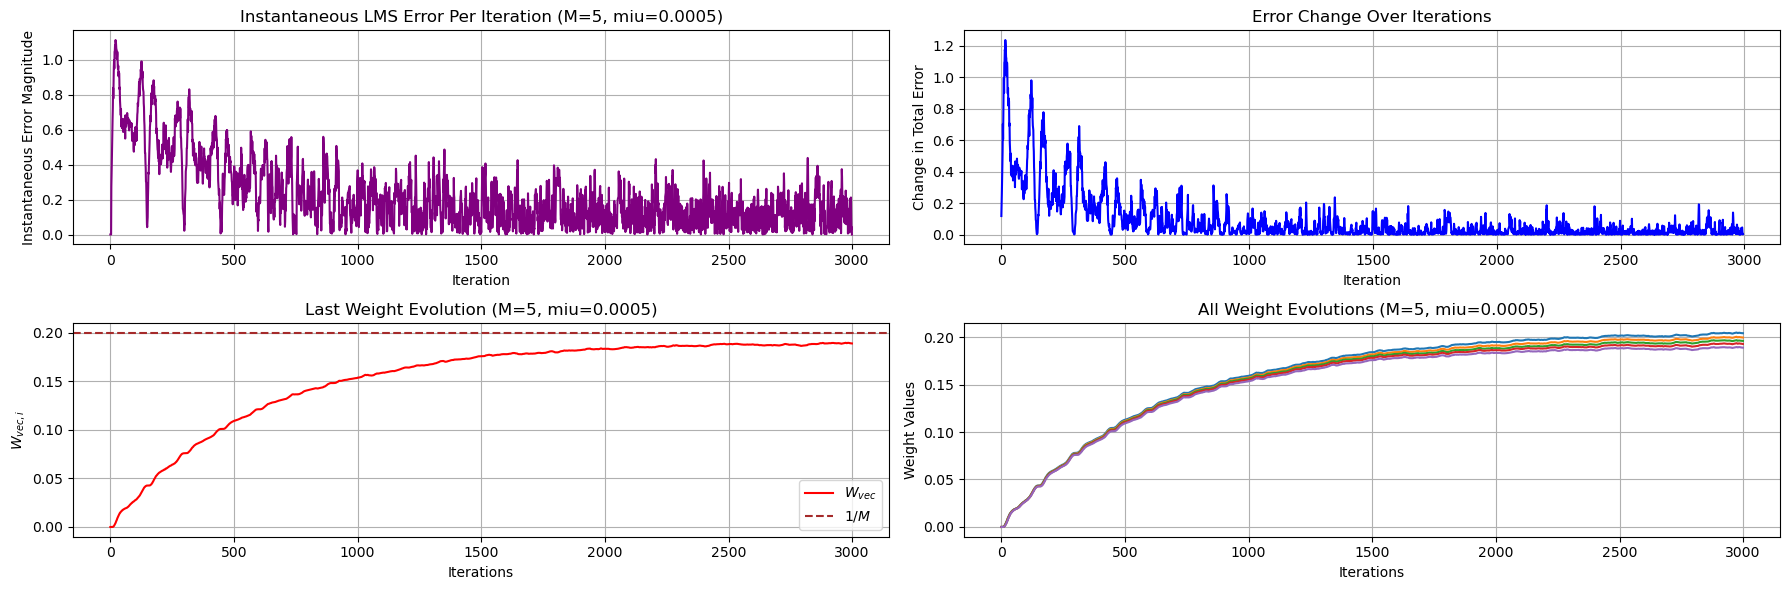

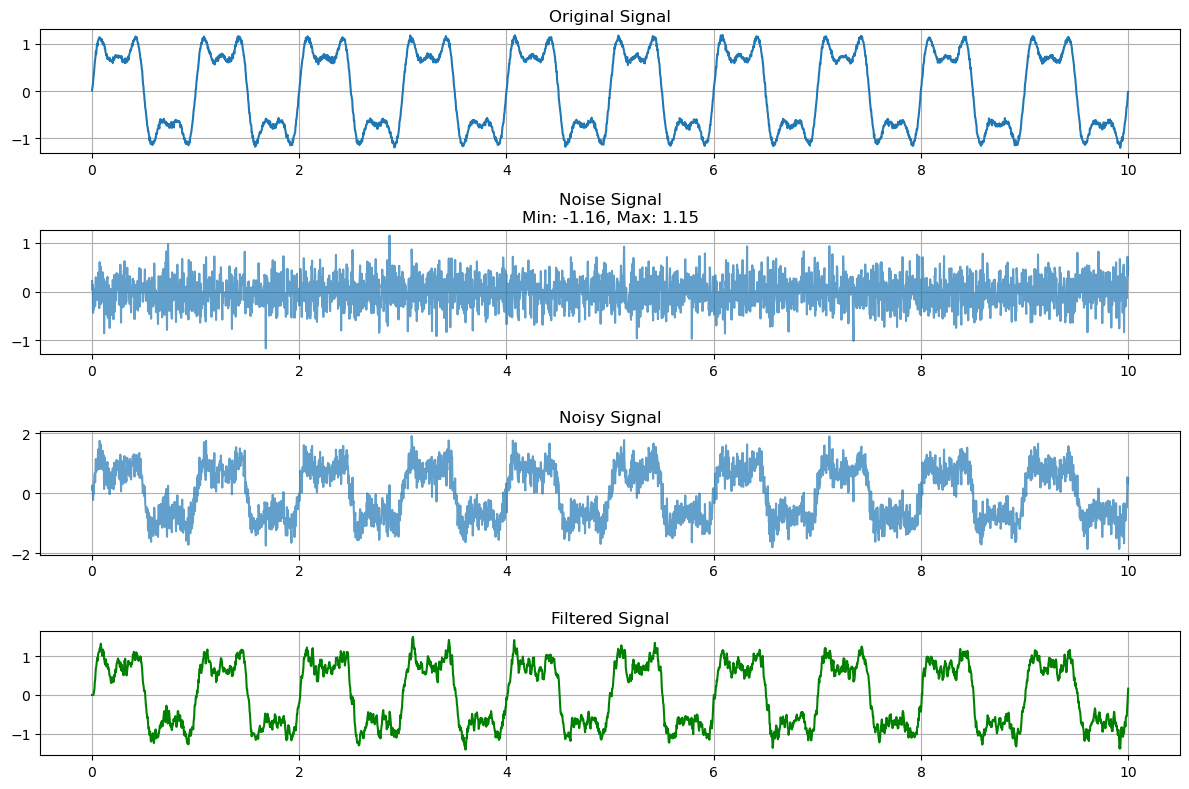

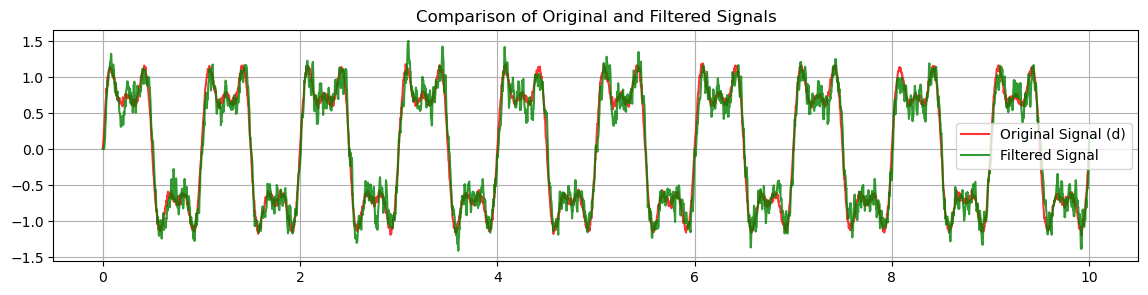

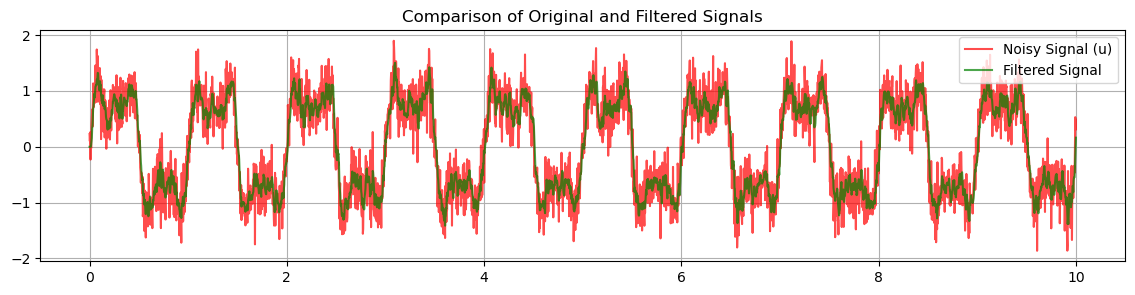

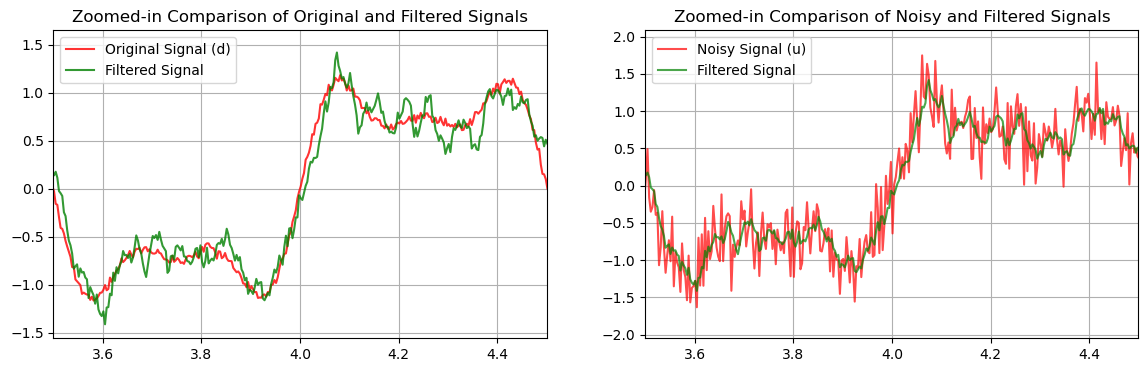

In [60]:
t = np.linspace(0, 10, 3000)  # time vector
signal = ( np.sin(2 * np.pi * t) + 0.5 * np.sin(2 * np.pi * 3 * t) + 
          0.25 * np.sin(2 * np.pi * 5 * t) + np.random.normal(0, 0.03, len(t)) )  # generate signal with  small noise

noise_level = 0.3  # define noise level
noise = np.random.normal(0, noise_level, len(t))  # generate Gaussian noise
noisy_signal = signal + noise  # add noise to the signal

M = 5  # number of filter coefficients
miu = 5e-4  # step size
totSamples = len(noisy_signal)
w = np.zeros((totSamples, M))  # initialize weights

d = signal  # desired signal
u = noisy_signal  # input signal (noisy)

newW, LMSErr, error_changes = LMS(u, d, w, M, totSamples, miu)  # apply lms algorithm
final_Ws = newW[-1, :]

filtered_signal = np.zeros_like(u)  # initialize filtered signal
for i in range(M, totSamples):
    filtered_signal[i] = np.dot(newW[-1, :], u[i - M + 1: i + 1][::-1])  # filter signal using final weights

plot_signal()

### Testing LMS Algorithm with Previously Computed Weights on a New Signal

In this test, I used the **LMS weights** computed in the previous signal to denoise a new signal with modified frequencies.

- **New Signal Description**:
  - The signal is a mix of different sine waves:
    - sin(2π * 2t) (basic frequency),
    - 0.5 * sin(2π * 5t) (fifth harmonic),
    - 0.25 * sin(2π * 7t) (seventh harmonic).
  - Small Gaussian noise (standard deviation = 0.03) was added for realism.
- **Observation**:
  - The results show that the previously computed LMS weights effectively reduce noise in the new signal.
  - The structure of the new signal is well-preserved after filtering.

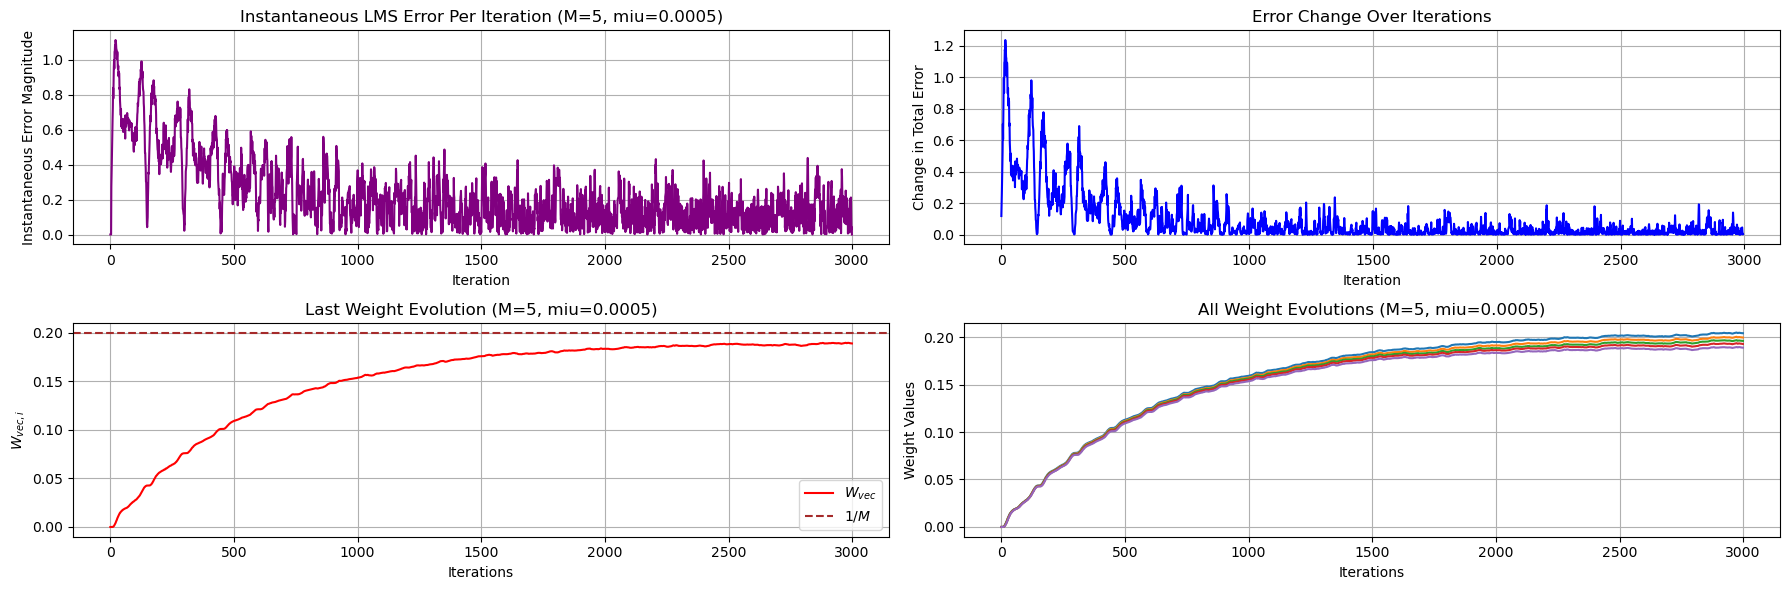

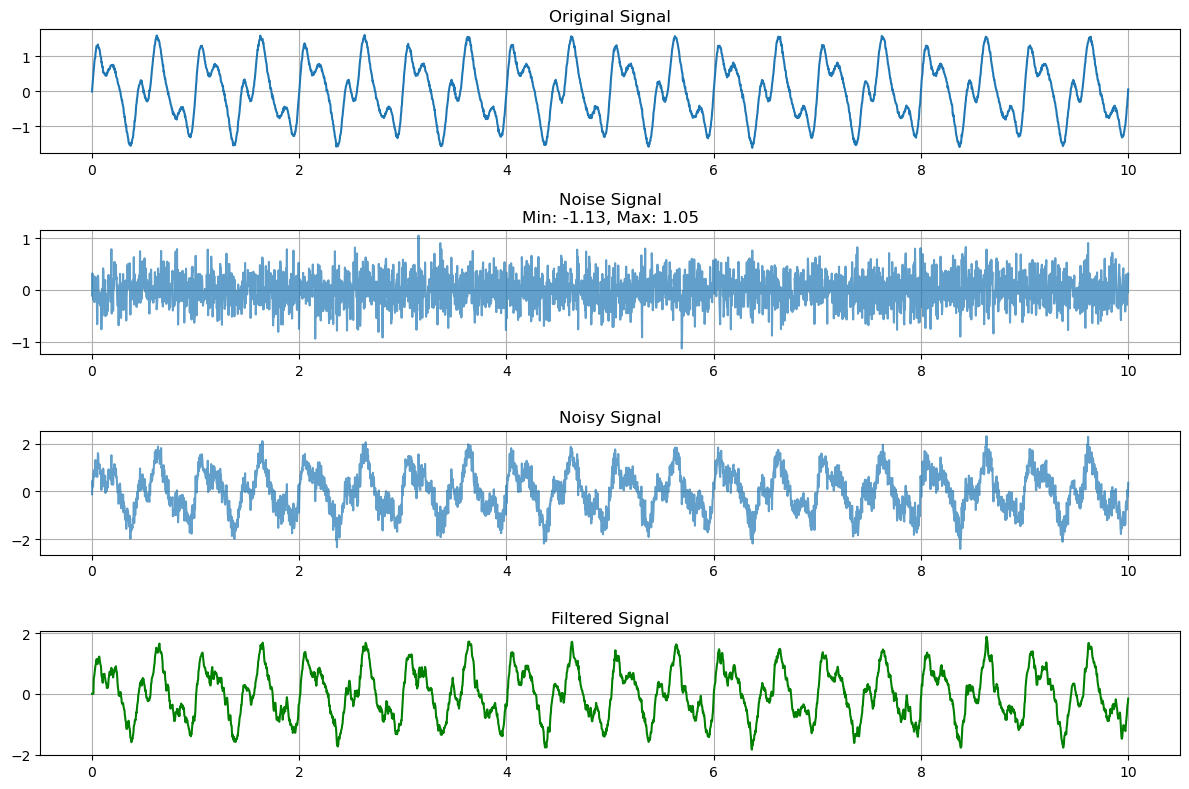

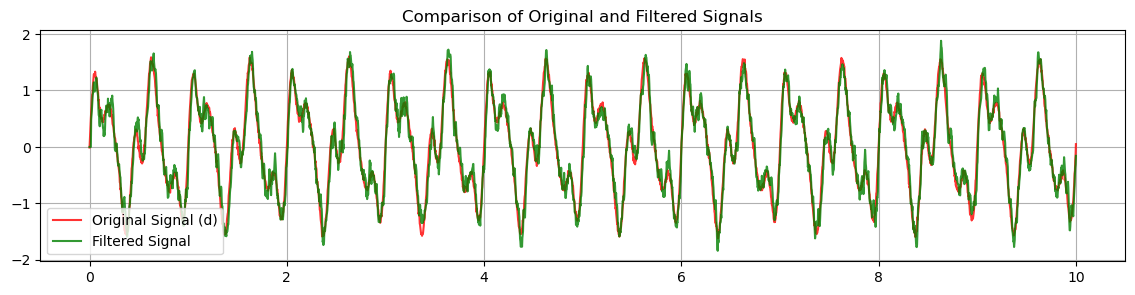

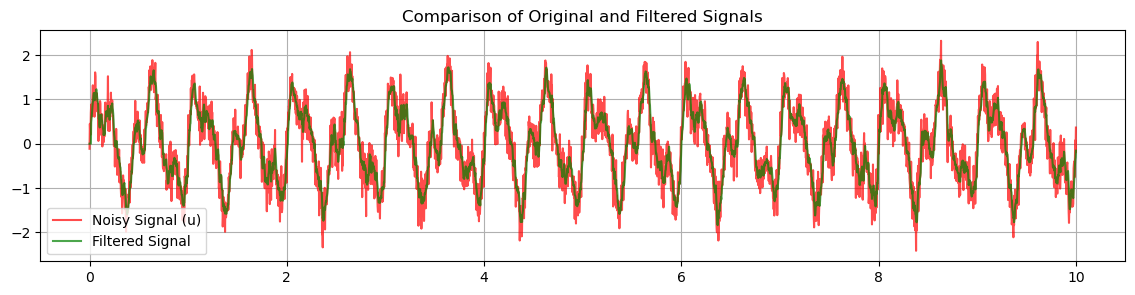

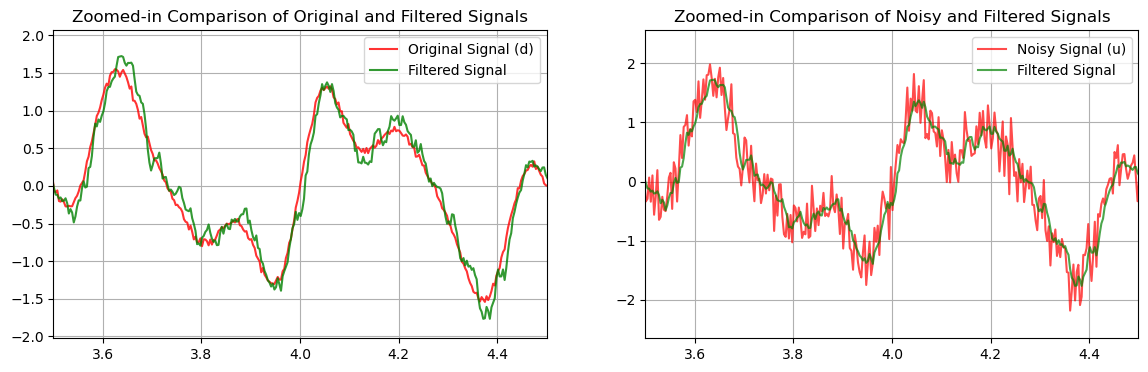

In [63]:
signal = ( np.sin(2 * np.pi * 2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t) + 
          0.25 * np.sin(2 * np.pi * 7 * t) + np.random.normal(0, 0.03, len(t)) )  # generate signal with  small noise

noise_level = 0.3  # define noise level
noise = np.random.normal(0, noise_level, len(t))  # generate Gaussian noise
noisy_signal = signal + noise

d = signal  # desired signal
u = noisy_signal  # input signal (noisy)

filtered_signal = np.zeros_like(u)  # initialize filtered signal
for i in range(M, totSamples):
    filtered_signal[i] = np.dot(final_Ws, u[i - M + 1: i + 1][::-1])  # filter signal using final weights

plot_signal()